# Fire Severity and Elevation Analysis

This notebook provides a comprehensive workflow for analyzing wildfire burn severity using Landsat 5 satellite imagery and correlating it with elevation data. The analysis uses the Normalized Burn Ratio (NBR) and difference NBR (dNBR) to quantify fire severity across elevation gradients.

## Overview

The analysis workflow includes:
1. Fire Data Loading - Load and process historical fire polygon data
2. Satellite Image Search - Find pre- and post-fire Landsat 5 imagery 
3. NBR Calculation - Compute Normalized Burn Ratio from NIR and SWIR2 bands
4. Fire Severity Classification - Classify burn severity using established dNBR thresholds
5. Elevation Analysis - Correlate fire severity patterns with topographic elevation
6. Statistical Analysis - Perform correlation analysis and elevation binning
7. Visualization - Generate comprehensive plots and summary statistics

## Key Features

### Fire Selection Methods
- By Name & Date: Target specific fires using incident name and fire date
- By Year: Select fires from a particular year with optional fire index
- Data Exploration: Browse available fires before analysis

### Landsat 5 Processing
- Time Range: Designed for fires from 1984-2013 (Landsat 5 operational period)
- Cloud Filtering: Prioritizes low cloud cover imagery
- 30-Day Search Window: Uses fixed 30 day buffer around target dates
- Collection 2 Processing: Applies proper scaling factors for surface reflectance

### Burn Severity Classification
Uses Key & Benson (2006) dNBR thresholds:
- High Severity: dNBR > 0.66
- Moderate-High: dNBR 0.44-0.66  
- Moderate-Low: dNBR 0.25-0.44
- Low Severity: dNBR 0.1-0.25
- Unburned: dNBR < 0.1

### Elevation Integration
- Data Source: OpenTopoData API with SRTM 30m DEM
- Spatial Analysis: Pixel-level correlation between dNBR and elevation
- Statistical Testing: Pearson correlation with significance testing
- Elevation Binning: Analyzes severity patterns across elevation zones

## Requirements

### Dependencies
- geopandas, pandas, numpy
- rioxarray, xarray
- pystac_client, planetary_computer
- matplotlib, seaborn, scipy
- requests, time

### Data Requirements
- Fire polygon GeoJSON file with FIRE_YEAR, INCIDENT, and UNQE_FIRE_ columns
- Internet connection for Landsat imagery and elevation data

## Output
The analysis produces:
- Fire severity percentages
- Elevation correlation analysis
- Statistical summary and visualizations
- Six-panel plot showing scatter plots, histograms, and severity distributions

## Limitations
- Designed specifically for Landsat 5 (1984-2013)
- Uses fixed 30-day search window for satellite imagery
- Requires internet connection for data access
- Limited by cloud cover in satellite imagery
- Elevation data subject to API rate limits

Note: After conceptualizing the workflow ourselves, Claude was used to help with debugging (was especially helpful at suggesting print outputs to aid in debugging) and module formatting. 

## Usage Examples

### Analyze by Fire Name and Date
```python
# Analyze a specific fire with known date
results = run_fire_elevation_analysis_by_date(
    fire_name='Monument Rock', 
    fire_date='1989-07-28'
)
```

### Analyze by Year
```python
# Analyze first fire from 1989
results = run_fire_elevation_analysis(target_year=1989, fire_index=0)
```

### Explore Available Data
```python
# Browse available fires
explore_available_fires(target_year=1989)
```

In [7]:
#import relevant libraries
import geopandas as gpd
import pandas as pd
import numpy as np
import rioxarray as rxr
import xarray as xr
import pystac_client
import planetary_computer as pc
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.interpolate import griddata
import requests
import time
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Libraries imported successfully!


### Functions for dNBR and Elevation Calculations and Visualization

#### Imports

In [ ]:
import geopandas as gpd
import pandas as pd
import numpy as np
import rioxarray as rxr
import pystac_client
import planetary_computer as pc
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import requests
import time
import warnings
warnings.filterwarnings('ignore')

#### Utility Functions

In [ ]:
"""
Data Utilities - Fire data loading and cleaning functions
"""

def clean_year(year_val):
    """Convert messy year data to clean integers"""
    if pd.isna(year_val):
        return None
    year_str = str(year_val)
    if '-' in year_str:
        return int(year_str.split('-')[0])
    return int(float(year_str))

def find_fire(fire_name, fire_file="../subsetted_data/mnf_fires_all.geojson"):
    """Find a fire by name in the dataset"""
    print(f"Looking for fire: {fire_name}")
    
    # Load fires
    fires = gpd.read_file(fire_file)
    fires['year'] = fires['FIRE_YEAR'].apply(clean_year)
    fires = fires.dropna(subset=['year']).to_crs('EPSG:4326')
    
    # Search
    matches = fires[fires['INCIDENT'].str.contains(fire_name, case=False, na=False)]
    
    if len(matches) == 0:
        print(f"No fires found with '{fire_name}' in the name")
        return None
    
    if len(matches) > 1:
        print(f"Found {len(matches)} matches:")
        for i, fire in matches.iterrows():
            print(f"  {fire['INCIDENT']} ({int(fire['year'])})")
    
    fire = matches.iloc[0]
    print(f"Using: {fire['INCIDENT']} ({int(fire['year'])})")
    return fire

#### Satellite imigery 

Now we need to access the landsat imagery data, which can be done like we did in class using pystac_client and accesssing from the microsoft planetary computer. We will specificy the collection we want, start and end dates bases on ignition dates, query for approppriate cloud cover. Note we must use time zone functions to avoid timezone errors.

In [ ]:
"""
Satellite Data Utilities - Landsat image search and NBR calculation
"""

def get_landsat_images(fire_polygon, target_date, days=30, direction='both'):
    """Get Landsat 5 images around a target date"""
        if direction == 'before':
        start_date = (target_date - timedelta(days=days_buffer)).strftime('%Y-%m-%d')
        end_date = target_date.strftime('%Y-%m-%d')
    elif direction == 'after':
        start_date = target_date.strftime('%Y-%m-%d')
        end_date = (target_date + timedelta(days=days_buffer)).strftime('%Y-%m-%d')
    else:  # 'both'
        start_date = (target_date - timedelta(days=days_buffer)).strftime('%Y-%m-%d')
        end_date = (target_date + timedelta(days=days_buffer)).strftime('%Y-%m-%d')
    
    print(f"Searching Landsat 5 from {start} to {end}")
    
    catalog = pystac_client.Client.open(
        "https://planetarycomputer.microsoft.com/api/stac/v1/",
        modifier=pc.sign_inplace
    )
    
    search = catalog.search(
        collections=["landsat-c2-l2"],
        intersects=fire_polygon.__geo_interface__,
        datetime=f"{start}/{end}",
        query={"platform": {"in": ["landsat-5"]}}
    )
    
    items = list(search.items())
    
    if len(items) == 0:
        print("No images found")
        return []
    
    # Sort by cloud cover
    items_sorted = []
    for item in items:
        clouds = item.properties.get('eo:cloud_cover', 100)
        date = pd.to_datetime(item.properties['datetime']).strftime('%Y-%m-%d')
        items_sorted.append((item, clouds, date))
    
    items_sorted.sort(key=lambda x: x[1])  # Sort by cloud cover
    
    print(f"Found {len(items_sorted)} images:")
    for i, (item, clouds, date) in enumerate(items_sorted[:3]):
        print(f"  {i+1}: {date}, {clouds:.1f}% clouds")
    
    return [item for item, _, _ in items_sorted]

def calculate_nbr(landsat_item, fire_polygon):
    """Calculate NBR from Landsat bands"""
    signed_item = pc.sign(landsat_item)
    
    date = landsat_item.properties.get('datetime', 'Unknown')
    clouds = landsat_item.properties.get('eo:cloud_cover', 'Unknown')
    print(f"Processing: {date}, {clouds}% clouds")
    
    # Find the right band names (they vary)
    available_bands = list(signed_item.assets.keys())
    print(f"Available bands: {available_bands}")
    
    # Look for NIR and SWIR bands
    nir_band = None
    swir_band = None
    
    for band in available_bands:
        if band in ['B04', 'nir08']:
            nir_band = band
        elif band in ['B07', 'swir22']:
            swir_band = band
    
    if nir_band is None or swir_band is None:
        print(f"ERROR: Can't find NIR ({nir_band}) or SWIR ({swir_band}) bands")
        return None
    
    print(f"Using {nir_band} (NIR) and {swir_band} (SWIR)")
    
    # Load NIR and SWIR bands
    nir = rxr.open_rasterio(signed_item.assets[nir_band].href)
    swir = rxr.open_rasterio(signed_item.assets[swir_band].href)
    
    # Convert fire to raster CRS and buffer it
    fire_gdf = gpd.GeoDataFrame([1], geometry=[fire_polygon], crs='EPSG:4326')
    fire_proj = fire_gdf.to_crs(nir.rio.crs).geometry.iloc[0]
    fire_buffered = fire_proj.buffer(2000)  # 2km buffer
    
    # Crop to fire area
    nir_crop = nir.rio.clip([fire_buffered], drop=True)
    swir_crop = swir.rio.clip([fire_buffered], drop=True)
    
    # Scale to reflectance (Landsat Collection 2)
    nir_refl = nir_crop * 0.0000275 - 0.2
    swir_refl = swir_crop * 0.0000275 - 0.2
    
    # Calculate NBR
    nbr = (nir_refl - swir_refl) / (nir_refl + swir_refl)
    
    # Clip to exact fire boundary
    nbr_fire = nbr.rio.clip([fire_proj], drop=True)
    
    print(f"NBR calculated, shape: {nbr_fire.shape}")
    return nbr_fire

Here, we are looking at nir and swird bands and calculating NBR using the following formula: NBR = (NIR - SWIR) / (NIR + SWIR)

#### Severity analysis

In [ ]:
"""
Burn Severity Analysis - Functions for calculating and categorizing fire severity
"""

def get_burn_severity_stats(dnbr_values):
    """Calculate burn severity statistics"""
    high = np.sum(dnbr_values > 0.66)
    mod_high = np.sum((dnbr_values >= 0.44) & (dnbr_values <= 0.66))
    mod_low = np.sum((dnbr_values >= 0.25) & (dnbr_values < 0.44))
    low = np.sum((dnbr_values >= 0.1) & (dnbr_values < 0.25))
    unburned = np.sum(dnbr_values < 0.1)
    total = len(dnbr_values)
    
    return {
        'high': (high, 100 * high / total),
        'mod_high': (mod_high, 100 * mod_high / total),
        'mod_low': (mod_low, 100 * mod_low / total),
        'low': (low, 100 * low / total),
        'unburned': (unburned, 100 * unburned / total),
        'total': total
    }

def classify_burn_severity(dnbr_value):
    """Classify a single dNBR value into severity category"""
    if dnbr_value > 0.66:
        return 'High'
    elif dnbr_value >= 0.44:
        return 'Moderate-High'
    elif dnbr_value >= 0.25:
        return 'Moderate-Low'
    elif dnbr_value >= 0.1:
        return 'Low'
    else:
        return 'Unburned'

def get_severity_thresholds():
    """Return standard dNBR severity thresholds"""
    return {
        'unburned': 0.1,
        'low': 0.25,
        'moderate_low': 0.44,
        'moderate_high': 0.66,
        'high': float('inf')
    }

#### Elevation

In [ ]:
"""
Elevation Data Utilities - Functions for getting and processing elevation data
"""

def get_elevation_points(fire_polygon, n_points=400):
    """Get elevation data using OpenTopoData API"""
    print("Getting elevation data...")
    
    # Get fire bounds with buffer
    fire_gdf = gpd.GeoDataFrame([1], geometry=[fire_polygon], crs='EPSG:4326')
    fire_utm = fire_gdf.to_crs('EPSG:3857')
    buffered = fire_utm.buffer(3000).to_crs('EPSG:4326')  # 3km buffer
    bounds = buffered.bounds.iloc[0]
    
    # Create grid of points
    n_side = int(np.sqrt(n_points))
    lats = np.linspace(bounds[1], bounds[3], n_side)
    lons = np.linspace(bounds[0], bounds[2], n_side)
    
    elevations = []
    coords = []
    
    for lat in lats:
        for lon in lons:
            try:
                url = f"https://api.opentopodata.org/v1/srtm30m?locations={lat},{lon}"
                response = requests.get(url, timeout=5)
                
                if response.status_code == 200:
                    data = response.json()
                    if data['status'] == 'OK' and len(data['results']) > 0:
                        elev = data['results'][0]['elevation']
                        if elev is not None:
                            elevations.append(elev)
                            coords.append((lon, lat))
                
                time.sleep(0.05)  # Be nice to the API
                
            except:
                continue
    
    print(f"Got {len(elevations)} elevation points")
    
    if len(elevations) < 50:
        print("Not enough elevation data")
        return None
    
    # Simple interpolation to create a grid
    from scipy.interpolate import griddata
    
    target_lats = np.linspace(bounds[1], bounds[3], 100)
    target_lons = np.linspace(bounds[0], bounds[2], 100)
    lon_grid, lat_grid = np.meshgrid(target_lons, target_lats)
    
    elev_grid = griddata(coords, elevations, (lon_grid, lat_grid), method='cubic')
    
    # Fill missing values
    if np.isnan(elev_grid).any():
        elev_grid_nn = griddata(coords, elevations, (lon_grid, lat_grid), method='nearest')
        elev_grid = np.where(np.isnan(elev_grid), elev_grid_nn, elev_grid)
    
    # Convert to xarray
    import xarray as xr
    elevation = xr.DataArray(
        elev_grid,
        coords={'y': target_lats, 'x': target_lons},
        dims=['y', 'x']
    ).rio.write_crs('EPSG:4326')
    
    print(f"Elevation range: {float(elevation.min()):.0f} - {float(elevation.max()):.0f} m")
    return elevation

#### Correlation analysis

In [ ]:
"""
Correlation Analysis - Functions for analyzing elevation vs fire severity relationships
"""

def analyze_elevation_vs_severity(dnbr, elevation, fire_polygon):
    """Correlate fire severity with elevation"""
    print("Analyzing elevation vs severity...")
    
    # Make sure both datasets match
    if dnbr.rio.crs != elevation.rio.crs:
        elevation = elevation.rio.reproject_match(dnbr)
    
    # Clip both to fire boundary
    fire_gdf = gpd.GeoDataFrame([1], geometry=[fire_polygon], crs='EPSG:4326')
    fire_proj = fire_gdf.to_crs(dnbr.rio.crs)
    
    dnbr_fire = dnbr.rio.clip(fire_proj.geometry, drop=True)
    elev_fire = elevation.rio.clip(fire_proj.geometry, drop=True)
    
    # Match shapes
    if dnbr_fire.shape != elev_fire.shape:
        elev_fire = elev_fire.rio.reproject_match(dnbr_fire)
    
    # Get clean data
    dnbr_flat = dnbr_fire.values.flatten()
    elev_flat = elev_fire.values.flatten()
    
    # Remove NaN values
    valid = ~(np.isnan(dnbr_flat) | np.isnan(elev_flat))
    dnbr_clean = dnbr_flat[valid]
    elev_clean = elev_flat[valid]
    
    print(f"Analyzing {len(dnbr_clean)} pixels")
    
    # Calculate correlation
    from scipy.stats import pearsonr
    correlation, p_value = pearsonr(dnbr_clean, elev_clean)
    
    # Bin by elevation
    n_bins = 6
    elev_bins = np.linspace(elev_clean.min(), elev_clean.max(), n_bins + 1)
    bin_centers = (elev_bins[:-1] + elev_bins[1:]) / 2
    
    severity_by_elev = []
    for i in range(n_bins):
        in_bin = (elev_clean >= elev_bins[i]) & (elev_clean < elev_bins[i + 1])
        if i == n_bins - 1:  # Include max value in last bin
            in_bin = (elev_clean >= elev_bins[i]) & (elev_clean <= elev_bins[i + 1])
        
        if np.sum(in_bin) > 0:
            bin_dnbr = dnbr_clean[in_bin]
            
            # Calculate all severity categories
            high_sev = 100 * np.sum(bin_dnbr > 0.66) / len(bin_dnbr)
            mod_high_sev = 100 * np.sum((bin_dnbr >= 0.44) & (bin_dnbr <= 0.66)) / len(bin_dnbr)
            mod_low_sev = 100 * np.sum((bin_dnbr >= 0.25) & (bin_dnbr < 0.44)) / len(bin_dnbr)
            low_sev = 100 * np.sum((bin_dnbr >= 0.1) & (bin_dnbr < 0.25)) / len(bin_dnbr)
            unburned = 100 * np.sum(bin_dnbr < 0.1) / len(bin_dnbr)
            
            severity_by_elev.append({
                'elevation': bin_centers[i],
                'mean_dnbr': np.mean(bin_dnbr),
                'high_severity': high_sev,
                'moderate_high': mod_high_sev,
                'moderate_low': mod_low_sev,
                'low_severity': low_sev,
                'unburned': unburned,
                'pixels': len(bin_dnbr)
            })
    
    return {
        'dnbr': dnbr_clean,
        'elevation': elev_clean,
        'correlation': correlation,
        'p_value': p_value,
        'elevation_bins': pd.DataFrame(severity_by_elev)
    }

#### Plots

We want to create 5 main plots:

1. Fire severity vs slevation
2. Mean fire severity by elevation
3. Burn severity by elevation (stacked plot)
4. Elevation distribution
5. dNBR distribution


In [ ]:
"""
Plotting Functions - Visualization of fire severity and elevation analysis results
"""

def plot_results(results, fire_name):
    """Make comprehensive plots like the original"""
    fig = plt.figure(figsize=(16, 10))
    
    # Scatter plot with trend line
    ax1 = plt.subplot(2, 3, 1)
    plt.scatter(results['elevation'], results['dnbr'], alpha=0.5, s=2, c='red')
    
    z = np.polyfit(results['elevation'], results['dnbr'], 1)
    p = np.poly1d(z)
    x_trend = np.linspace(results['elevation'].min(), results['elevation'].max(), 100)
    plt.plot(x_trend, p(x_trend), 'blue', linewidth=2, alpha=0.8)
    
    plt.xlabel('Elevation (m)')
    plt.ylabel('dNBR')
    plt.title(f'Fire Severity vs Elevation\nr = {results["correlation"]:.3f}, p = {results["p_value"]:.4f}')
    plt.grid(True, alpha=0.3)
    
    # Mean dNBR by elevation
    ax2 = plt.subplot(2, 3, 2)
    bins = results['elevation_bins']
    plt.plot(bins['elevation'], bins['mean_dnbr'], 'o-', linewidth=2, markersize=8, color='darkred')
    plt.xlabel('Elevation (m)')
    plt.ylabel('Mean dNBR')
    plt.title('Mean Fire Severity by Elevation')
    plt.grid(True, alpha=0.3)
    
    # Stacked bar chart of ALL severity categories by elevation
    ax3 = plt.subplot(2, 3, 3)
    x_pos = np.arange(len(bins))
    
    # Get all severity percentages
    high_pct = bins['high_severity']
    mod_high_pct = bins['moderate_high']
    mod_low_pct = bins['moderate_low']
    low_pct = bins['low_severity']
    unburned_pct = bins['unburned']
    
    # Create stacked bars with all categories
    plt.bar(x_pos, high_pct, label='High (>0.66)', color='darkred')
    plt.bar(x_pos, mod_high_pct, bottom=high_pct, label='Mod-High (0.44-0.66)', color='red')
    plt.bar(x_pos, mod_low_pct, bottom=high_pct + mod_high_pct, label='Mod-Low (0.25-0.44)', color='orange')
    plt.bar(x_pos, low_pct, bottom=high_pct + mod_high_pct + mod_low_pct, label='Low (0.1-0.25)', color='yellow')
    plt.bar(x_pos, unburned_pct, bottom=high_pct + mod_high_pct + mod_low_pct + low_pct, label='Unburned (<0.1)', color='green')
    
    plt.xlabel('Elevation Bin')
    plt.ylabel('Percentage')
    plt.title('Burn Severity by Elevation')
    plt.xticks(x_pos, [f"{elev:.0f}m" for elev in bins['elevation']], rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    
    # Elevation histogram
    ax4 = plt.subplot(2, 3, 4)
    plt.hist(results['elevation'], bins=30, alpha=0.7, color='brown', edgecolor='black')
    plt.xlabel('Elevation (m)')
    plt.ylabel('Pixels')
    plt.title('Elevation Distribution')
    plt.grid(True, alpha=0.3)
    
    # dNBR histogram
    ax5 = plt.subplot(2, 3, 5)
    plt.hist(results['dnbr'], bins=30, alpha=0.7, color='red', edgecolor='black')
    plt.xlabel('dNBR')
    plt.ylabel('Pixels')
    plt.title('dNBR Distribution')
    plt.grid(True, alpha=0.3)
    
    # Summary statistics box
    ax6 = plt.subplot(2, 3, 6)
    ax6.axis('off')
    
    corr_abs = abs(results['correlation'])
    strength = "Strong" if corr_abs > 0.7 else "Moderate" if corr_abs > 0.3 else "Weak"
    direction = "positive" if results['correlation'] > 0 else "negative"
    significance = "significant" if results['p_value'] < 0.05 else "not significant"
    
    summary_text = f"""ELEVATION ANALYSIS SUMMARY

Fire: {fire_name}
Pixels: {len(results['dnbr']):,}

Elevation:
• Range: {results['elevation'].min():.0f} - {results['elevation'].max():.0f} m
• Mean: {results['elevation'].mean():.0f} m

dNBR:
• Range: {results['dnbr'].min():.3f} - {results['dnbr'].max():.3f}
• Mean: {results['dnbr'].mean():.3f}

Correlation:
• r = {results['correlation']:.4f}
• p = {results['p_value']:.6f}
• {strength} {direction} correlation
• {significance} (α=0.05)"""
    
    ax6.text(0.05, 0.95, summary_text, transform=ax6.transAxes, fontsize=10,
             verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    
    plt.suptitle(f'{fire_name} - Fire Severity vs Elevation Analysis', fontsize=16, y=0.98)
    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    plt.show()

#### Main analysis

In [ ]:
"""
Main Analysis Functions - Core workflow for fire severity and elevation analysis
"""

def analyze_fire(fire_name, fire_date, fire_file="../subsetted_data/mnf_fires_all.geojson"):
    """
    Main function - analyze a fire by name and date
    
    Example: analyze_fire("Canyon Creek", "1989-08-04")
    """
    print(f"FIRE ANALYSIS: {fire_name}")
    
    # Find the fire
    fire = find_fire(fire_name, fire_file)
    if fire is None:
        return None
    
    # Set up dates
    fire_date = pd.to_datetime(fire_date)
    pre_fire_date = fire_date - timedelta(days=30)
    post_fire_date = fire_date + timedelta(days=365)
    
    print(f"Dates:")
    print(f"  Fire: {fire_date.strftime('%Y-%m-%d')}")
    print(f"  Pre-fire search: {pre_fire_date.strftime('%Y-%m-%d')}")
    print(f"  Post-fire search: {post_fire_date.strftime('%Y-%m-%d')}")
    
    # Get satellite images
    print(f"Getting pre-fire imagery...")
    pre_images = get_landsat_images(fire.geometry, pre_fire_date)
    if len(pre_images) == 0:
        return None
    
    print(f"Getting post-fire imagery...")
    post_images = get_landsat_images(fire.geometry, post_fire_date)
    if len(post_images) == 0:
        return None
    
    # Calculate NBR
    print(f"Calculating pre-fire NBR...")
    pre_nbr = calculate_nbr(pre_images[0], fire.geometry)
    
    print(f"Calculating post-fire NBR...")
    post_nbr = calculate_nbr(post_images[0], fire.geometry)
    
    # Calculate dNBR
    print(f"Calculating dNBR...")
    if pre_nbr.rio.crs != post_nbr.rio.crs:
        post_nbr = post_nbr.rio.reproject_match(pre_nbr)
    
    dnbr = pre_nbr - post_nbr
    dnbr_values = dnbr.values.flatten()
    dnbr_clean = dnbr_values[~np.isnan(dnbr_values)]
    
    print(f"dNBR stats: mean={np.mean(dnbr_clean):.3f}, range={np.min(dnbr_clean):.3f} to {np.max(dnbr_clean):.3f}")
    
    # Burn severity stats
    severity = get_burn_severity_stats(dnbr_clean)
    print(f"Burn Severity ({severity['total']} pixels):")
    print(f"  High (>0.66):       {severity['high'][0]:4d} ({severity['high'][1]:4.1f}%)")
    print(f"  Moderate-High:      {severity['mod_high'][0]:4d} ({severity['mod_high'][1]:4.1f}%)")
    print(f"  Moderate-Low:       {severity['mod_low'][0]:4d} ({severity['mod_low'][1]:4.1f}%)")
    print(f"  Low (0.1-0.25):     {severity['low'][0]:4d} ({severity['low'][1]:4.1f}%)")
    print(f"  Unburned (<0.1):    {severity['unburned'][0]:4d} ({severity['unburned'][1]:4.1f}%)")
    
    # Get elevation data
    print(f"Getting elevation data...")
    elevation = get_elevation_points(fire.geometry)
    if elevation is None:
        print("Skipping elevation analysis")
        return {'fire': fire, 'dnbr': dnbr, 'severity': severity}
    
    # Elevation analysis
    print(f"Analyzing elevation vs severity...")
    elev_results = analyze_elevation_vs_severity(dnbr, elevation, fire.geometry)
    
    # Print detailed results
    print("======================================================================")
    print("FIRE SEVERITY + ELEVATION ANALYSIS RESULTS")
    print("======================================================================")
    
    print(f"Fire Information:")
    print(f"Name: {fire['INCIDENT']}")
    print(f"ID: {fire.get('UNQE_FIRE_', 'Unknown')}")
    print(f"Year: {int(fire['year'])}")
    print(f"Fire Date: {fire_date.strftime('%Y-%m-%d')}")
    print(f"Satellite: Landsat 5 (30m resolution)")
    
    print(f"Spatial Analysis:")
    print(f"Total analyzed pixels: {len(elev_results['dnbr']):,}")
    print(f"Fire area: {fire.geometry.area:.8f} square degrees")
    
    print(f"Elevation Summary:")
    print(f"Range: {elev_results['elevation'].min():.0f} - {elev_results['elevation'].max():.0f} m")
    print(f"Mean: {elev_results['elevation'].mean():.0f} m")
    print(f"Relief: {elev_results['elevation'].max() - elev_results['elevation'].min():.0f} m")
    
    print(f"Fire Severity Summary:")
    print(f"dNBR Range: {elev_results['dnbr'].min():.3f} - {elev_results['dnbr'].max():.3f}")
    print(f"Mean dNBR: {elev_results['dnbr'].mean():.3f}")
    
    print(f"Elevation-Fire Severity Correlation:")
    print(f"Pearson correlation: {elev_results['correlation']:.4f}")
    print(f"P-value: {elev_results['p_value']:.6f}")
    print(f"Statistical significance: {'Yes' if elev_results['p_value'] < 0.05 else 'No'} (α=0.05)")
    
    # Interpretation
    corr_abs = abs(elev_results['correlation'])
    if corr_abs > 0.3:
        strength = "strong" if corr_abs > 0.7 else "moderate"
    else:
        strength = "weak"
    
    direction = "positive" if elev_results['correlation'] > 0 else "negative"
    
    print(f"Interpretation:")
    print(f"There is a {strength} {direction} correlation between elevation and fire severity.")
    
    if elev_results['correlation'] > 0.1:
        print(f"Higher elevations experienced more severe burning on average.")
    elif elev_results['correlation'] < -0.1:
        print(f"Lower elevations experienced more severe burning on average.")
    else:
        print(f"Elevation does not strongly influence fire severity in this fire.")
    
    # Elevation-based severity table
    bins_df = elev_results['elevation_bins']
    print(f"Detailed Severity by Elevation Zones:")
    print(f"{'Elevation (m)':<12} {'Mean dNBR':<10} {'High Sev %':<11} {'Mod-High %':<11} {'Pixels':<8}")
    print("------------------------------------------------------------------")
    for _, row in bins_df.iterrows():
        print(f"{row['elevation']:<12.0f} {row['mean_dnbr']:<10.3f} "
              f"{row['high_severity']:<11.1f} {row['moderate_high']:<11.1f} {row['pixels']:<8.0f}")
    
    # Make plots
    print(f"Creating plots...")
    plot_results(elev_results, f"{fire['INCIDENT']} ({fire_date.strftime('%Y')})")
    
    print(f"Analysis complete!")
    
    return {
        'fire': fire,
        'dnbr': dnbr,
        'elevation': elevation,
        'severity': severity,
        'elevation_analysis': elev_results
    }

def run_fire_elevation_analysis_by_date(fire_name, fire_date, fire_file="../subsetted_data/mnf_fires_all.geojson"):
    """
    Complete workflow function - matches the original function name
    
    Example: run_fire_elevation_analysis_by_date("Monument Rock", "1989-07-28")
    """
    return analyze_fire(fire_name, fire_date, fire_file)

#### Examples

In [ ]:
"""
Usage Examples and Documentation

This tool provides examples of how to use the fire analysis functions.
"""

# Simple usage examples
if __name__ == "__main__":
    print("Simple Fire Analysis")
    print("===================")
    print()
    print("Usage:")
    print("  results = run_fire_elevation_analysis_by_date('Monument Rock', '1989-07-28')")
    print("  results = run_fire_elevation_analysis_by_date('Canyon Creek', '1989-08-04')")
    print()
    print("The function will:")
    print("  1. Find your fire by name")
    print("  2. Get Landsat imagery before and after the fire")
    print("  3. Calculate burn severity (dNBR)")
    print("  4. Download elevation data")
    print("  5. Analyze how elevation affects fire severity")
    print("  6. Make plots")

"""
COMPLETE WORKFLOW DOCUMENTATION:

Fire Analysis Elevation and Burn Severity Module

Analyzes wildfire burn severity using Landsat 5 NBR and correlates with elevation data.
Clean, readable code for graduate students without unnecessary complexity.

Functions:
- clean_year(): Convert messy year data to clean integers
- find_fire(): Find a fire by name in the dataset
- get_landsat_images(): Get Landsat 5 images around a target date
- calculate_nbr(): Calculate NBR from Landsat bands
- get_burn_severity_stats(): Calculate burn severity statistics
- get_elevation_points(): Get elevation data using OpenTopoData API
- analyze_elevation_vs_severity(): Correlate fire severity with elevation
- plot_results(): Make comprehensive 6-panel plots
- analyze_fire(): Main analysis function
- run_fire_elevation_analysis_by_date(): Complete workflow function

Usage:
    results = run_fire_elevation_analysis_by_date('Monument Rock', '1989-07-28')
    results = run_fire_elevation_analysis_by_date('Canyon Creek', '1989-08-04')

The function will:
  1. Find your fire by name
  2. Get Landsat imagery before and after the fire
  3. Calculate burn severity (dNBR)
  4. Download elevation data
  5. Analyze how elevation affects fire severity
  6. Make comprehensive plots with all severity categories
"""

#### Fire severity vs elevation analysis function

In [14]:
# Create comprehensive plots of fire severity vs elevation.
def plot_elevation_analysis(results, fire_name="Fire"):
  
    fig = plt.figure(figsize=(16, 10))
    
    # Scatter plot with trend line
    ax1 = plt.subplot(2, 3, 1)
    plt.scatter(results['elevation_values'], results['dnbr_values'], 
                alpha=0.5, s=2, c='red')
    
    z = np.polyfit(results['elevation_values'], results['dnbr_values'], 1)
    p = np.poly1d(z)
    x_trend = np.linspace(results['elevation_values'].min(), 
                         results['elevation_values'].max(), 100)
    plt.plot(x_trend, p(x_trend), 'blue', linewidth=2, alpha=0.8)
    
    plt.xlabel('Elevation (m)')
    plt.ylabel('dNBR')
    plt.title(f'Fire Severity vs Elevation\nr = {results["correlation"]:.3f}, p = {results["p_value"]:.4f}')
    plt.grid(True, alpha=0.3)
    
    # Mean dNBR by elevation
    ax2 = plt.subplot(2, 3, 2)
    severity_df = results['severity_by_elevation']
    plt.plot(severity_df['elevation'], severity_df['mean_dnbr'], 
             'o-', linewidth=2, markersize=8, color='darkred')
    plt.xlabel('Elevation (m)')
    plt.ylabel('Mean dNBR')
    plt.title('Mean Fire Severity by Elevation')
    plt.grid(True, alpha=0.3)
    
    # Stacked bar chart
    ax3 = plt.subplot(2, 3, 3)
    x_pos = np.arange(len(severity_df))
    
    plt.bar(x_pos, severity_df['high_severity'], label='High (>0.66)', color='darkred')
    plt.bar(x_pos, severity_df['moderate_high'], 
            bottom=severity_df['high_severity'], label='Mod-High (0.44-0.66)', color='red')
    plt.bar(x_pos, severity_df['moderate_low'], 
            bottom=severity_df['high_severity'] + severity_df['moderate_high'], 
            label='Mod-Low (0.25-0.44)', color='orange')
    plt.bar(x_pos, severity_df['low_severity'], 
            bottom=severity_df['high_severity'] + severity_df['moderate_high'] + severity_df['moderate_low'], 
            label='Low (0.1-0.25)', color='yellow')
    plt.bar(x_pos, severity_df['unburned'],
            bottom=severity_df['high_severity'] + severity_df['moderate_high'] + 
                   severity_df['moderate_low'] + severity_df['low_severity'],
            label='Unburned (<0.1)', color='green')
    
    plt.xlabel('Elevation Bin')
    plt.ylabel('Percentage')
    plt.title('Burn Severity by Elevation')
    plt.xticks(x_pos, [f"{elev:.0f}m" for elev in severity_df['elevation']], rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    
    # Elevation histogram
    ax4 = plt.subplot(2, 3, 4)
    plt.hist(results['elevation_values'], bins=30, alpha=0.7, color='brown', edgecolor='black')
    plt.xlabel('Elevation (m)')
    plt.ylabel('Pixels')
    plt.title('Elevation Distribution')
    plt.grid(True, alpha=0.3)
    
    # dNBR histogram
    ax5 = plt.subplot(2, 3, 5)
    plt.hist(results['dnbr_values'], bins=30, alpha=0.7, color='red', edgecolor='black')
    plt.xlabel('dNBR')
    plt.ylabel('Pixels')
    plt.title('dNBR Distribution')
    plt.grid(True, alpha=0.3)
    
    # Summary statistics
    ax6 = plt.subplot(2, 3, 6)
    ax6.axis('off')
    
    corr_abs = abs(results['correlation'])
    strength = "Strong" if corr_abs > 0.7 else "Moderate" if corr_abs > 0.3 else "Weak"
    direction = "positive" if results['correlation'] > 0 else "negative"
    significance = "significant" if results['p_value'] < 0.05 else "not significant"
    
    summary_text = f"""ELEVATION ANALYSIS SUMMARY

Fire: {fire_name}
Pixels: {len(results['dnbr_values']):,}

Elevation:
• Range: {results['elevation_values'].min():.0f} - {results['elevation_values'].max():.0f} m
• Mean: {results['elevation_values'].mean():.0f} m

dNBR:
• Range: {results['dnbr_values'].min():.3f} - {results['dnbr_values'].max():.3f}
• Mean: {results['dnbr_values'].mean():.3f}

Correlation:
• r = {results['correlation']:.4f}
• p = {results['p_value']:.6f}
• {strength} {direction} correlation
• {significance} (α=0.05)"""
    
    ax6.text(0.05, 0.95, summary_text, transform=ax6.transAxes, fontsize=10,
             verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    
    plt.suptitle(f'{fire_name} - Fire Severity vs Elevation Analysis', fontsize=16, y=0.98)
    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    plt.show()

print("Plotting function defined!")

Plotting function defined!


#### Main analysis function that works by fire name and date

This is a chonky one and is the meat of the analysis where we put together dNBR with elevation

In [8]:
import geopandas as gpd
import pandas as pd
import numpy as np
import rioxarray as rxr
import pystac_client
import planetary_computer as pc
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import requests
import time
import warnings
warnings.filterwarnings('ignore')

def clean_year(year_val):
    """Convert messy year data to clean integers"""
    if pd.isna(year_val):
        return None
    year_str = str(year_val)
    if '-' in year_str:
        return int(year_str.split('-')[0])
    return int(float(year_str))

def find_fire(fire_name, fire_file="../subsetted_data/mnf_fires_all.geojson"):
    """Find a fire by name in the dataset"""
    print(f"Looking for fire: {fire_name}")
    
    # Load fires
    fires = gpd.read_file(fire_file)
    fires['year'] = fires['FIRE_YEAR'].apply(clean_year)
    fires = fires.dropna(subset=['year']).to_crs('EPSG:4326')
    
    # Search
    matches = fires[fires['INCIDENT'].str.contains(fire_name, case=False, na=False)]
    
    if len(matches) == 0:
        print(f"No fires found with '{fire_name}' in the name")
        return None
    
    if len(matches) > 1:
        print(f"Found {len(matches)} matches:")
        for i, fire in matches.iterrows():
            print(f"  {fire['INCIDENT']} ({int(fire['year'])})")
    
    fire = matches.iloc[0]
    print(f"Using: {fire['INCIDENT']} ({int(fire['year'])})")
    return fire

def get_landsat_images(fire_polygon, target_date, days=30):
    """Get Landsat 5 images around a target date"""
    start = (target_date - timedelta(days=days)).strftime('%Y-%m-%d')
    end = (target_date + timedelta(days=days)).strftime('%Y-%m-%d')
    
    print(f"Searching Landsat 5 from {start} to {end}")
    
    catalog = pystac_client.Client.open(
        "https://planetarycomputer.microsoft.com/api/stac/v1/",
        modifier=pc.sign_inplace
    )
    
    search = catalog.search(
        collections=["landsat-c2-l2"],
        intersects=fire_polygon.__geo_interface__,
        datetime=f"{start}/{end}",
        query={"platform": {"in": ["landsat-5"]}}
    )
    
    items = list(search.items())
    
    if len(items) == 0:
        print("No images found")
        return []
    
    # Sort by cloud cover
    items_sorted = []
    for item in items:
        clouds = item.properties.get('eo:cloud_cover', 100)
        date = pd.to_datetime(item.properties['datetime']).strftime('%Y-%m-%d')
        items_sorted.append((item, clouds, date))
    
    items_sorted.sort(key=lambda x: x[1])  # Sort by cloud cover
    
    print(f"Found {len(items_sorted)} images:")
    for i, (item, clouds, date) in enumerate(items_sorted[:3]):
        print(f"  {i+1}: {date}, {clouds:.1f}% clouds")
    
    return [item for item, _, _ in items_sorted]

def calculate_nbr(landsat_item, fire_polygon):
    """Calculate NBR from Landsat bands"""
    signed_item = pc.sign(landsat_item)
    
    date = landsat_item.properties.get('datetime', 'Unknown')
    clouds = landsat_item.properties.get('eo:cloud_cover', 'Unknown')
    print(f"Processing: {date}, {clouds}% clouds")
    
    # Find the right band names (they vary)
    available_bands = list(signed_item.assets.keys())
    print(f"Available bands: {available_bands}")
    
    # Look for NIR and SWIR bands
    nir_band = None
    swir_band = None
    
    for band in available_bands:
        if band in ['B04', 'nir08']:
            nir_band = band
        elif band in ['B07', 'swir22']:
            swir_band = band
    
    if nir_band is None or swir_band is None:
        print(f"ERROR: Can't find NIR ({nir_band}) or SWIR ({swir_band}) bands")
        return None
    
    print(f"Using {nir_band} (NIR) and {swir_band} (SWIR)")
    
    # Load NIR and SWIR bands
    nir = rxr.open_rasterio(signed_item.assets[nir_band].href)
    swir = rxr.open_rasterio(signed_item.assets[swir_band].href)
    
    # Convert fire to raster CRS and buffer it
    fire_gdf = gpd.GeoDataFrame([1], geometry=[fire_polygon], crs='EPSG:4326')
    fire_proj = fire_gdf.to_crs(nir.rio.crs).geometry.iloc[0]
    fire_buffered = fire_proj.buffer(2000)  # 2km buffer
    
    # Crop to fire area
    nir_crop = nir.rio.clip([fire_buffered], drop=True)
    swir_crop = swir.rio.clip([fire_buffered], drop=True)
    
    # Scale to reflectance (Landsat Collection 2)
    nir_refl = nir_crop * 0.0000275 - 0.2
    swir_refl = swir_crop * 0.0000275 - 0.2
    
    # Calculate NBR
    nbr = (nir_refl - swir_refl) / (nir_refl + swir_refl)
    
    # Clip to exact fire boundary
    nbr_fire = nbr.rio.clip([fire_proj], drop=True)
    
    print(f"NBR calculated, shape: {nbr_fire.shape}")
    return nbr_fire

def get_burn_severity_stats(dnbr_values):
    """Calculate burn severity statistics"""
    high = np.sum(dnbr_values > 0.66)
    mod_high = np.sum((dnbr_values >= 0.44) & (dnbr_values <= 0.66))
    mod_low = np.sum((dnbr_values >= 0.25) & (dnbr_values < 0.44))
    low = np.sum((dnbr_values >= 0.1) & (dnbr_values < 0.25))
    unburned = np.sum(dnbr_values < 0.1)
    total = len(dnbr_values)
    
    return {
        'high': (high, 100 * high / total),
        'mod_high': (mod_high, 100 * mod_high / total),
        'mod_low': (mod_low, 100 * mod_low / total),
        'low': (low, 100 * low / total),
        'unburned': (unburned, 100 * unburned / total),
        'total': total
    }

def get_elevation_points(fire_polygon, n_points=400):
    """Get elevation data using OpenTopoData API"""
    print("Getting elevation data...")
    
    # Get fire bounds with buffer
    fire_gdf = gpd.GeoDataFrame([1], geometry=[fire_polygon], crs='EPSG:4326')
    fire_utm = fire_gdf.to_crs('EPSG:3857')
    buffered = fire_utm.buffer(3000).to_crs('EPSG:4326')  # 3km buffer
    bounds = buffered.bounds.iloc[0]
    
    # Create grid of points
    n_side = int(np.sqrt(n_points))
    lats = np.linspace(bounds[1], bounds[3], n_side)
    lons = np.linspace(bounds[0], bounds[2], n_side)
    
    elevations = []
    coords = []
    
    for lat in lats:
        for lon in lons:
            try:
                url = f"https://api.opentopodata.org/v1/srtm30m?locations={lat},{lon}"
                response = requests.get(url, timeout=5)
                
                if response.status_code == 200:
                    data = response.json()
                    if data['status'] == 'OK' and len(data['results']) > 0:
                        elev = data['results'][0]['elevation']
                        if elev is not None:
                            elevations.append(elev)
                            coords.append((lon, lat))
                
                time.sleep(0.05)  # Be nice to the API
                
            except:
                continue
    
    print(f"Got {len(elevations)} elevation points")
    
    if len(elevations) < 50:
        print("Not enough elevation data")
        return None
    
    # Simple interpolation to create a grid
    from scipy.interpolate import griddata
    
    target_lats = np.linspace(bounds[1], bounds[3], 100)
    target_lons = np.linspace(bounds[0], bounds[2], 100)
    lon_grid, lat_grid = np.meshgrid(target_lons, target_lats)
    
    elev_grid = griddata(coords, elevations, (lon_grid, lat_grid), method='cubic')
    
    # Fill missing values
    if np.isnan(elev_grid).any():
        elev_grid_nn = griddata(coords, elevations, (lon_grid, lat_grid), method='nearest')
        elev_grid = np.where(np.isnan(elev_grid), elev_grid_nn, elev_grid)
    
    # Convert to xarray
    import xarray as xr
    elevation = xr.DataArray(
        elev_grid,
        coords={'y': target_lats, 'x': target_lons},
        dims=['y', 'x']
    ).rio.write_crs('EPSG:4326')
    
    print(f"Elevation range: {float(elevation.min()):.0f} - {float(elevation.max()):.0f} m")
    return elevation

def analyze_elevation_vs_severity(dnbr, elevation, fire_polygon):
    """Correlate fire severity with elevation"""
    print("Analyzing elevation vs severity...")
    
    # Make sure both datasets match
    if dnbr.rio.crs != elevation.rio.crs:
        elevation = elevation.rio.reproject_match(dnbr)
    
    # Clip both to fire boundary
    fire_gdf = gpd.GeoDataFrame([1], geometry=[fire_polygon], crs='EPSG:4326')
    fire_proj = fire_gdf.to_crs(dnbr.rio.crs)
    
    dnbr_fire = dnbr.rio.clip(fire_proj.geometry, drop=True)
    elev_fire = elevation.rio.clip(fire_proj.geometry, drop=True)
    
    # Match shapes
    if dnbr_fire.shape != elev_fire.shape:
        elev_fire = elev_fire.rio.reproject_match(dnbr_fire)
    
    # Get clean data
    dnbr_flat = dnbr_fire.values.flatten()
    elev_flat = elev_fire.values.flatten()
    
    # Remove NaN values
    valid = ~(np.isnan(dnbr_flat) | np.isnan(elev_flat))
    dnbr_clean = dnbr_flat[valid]
    elev_clean = elev_flat[valid]
    
    print(f"Analyzing {len(dnbr_clean)} pixels")
    
    # Calculate correlation
    from scipy.stats import pearsonr
    correlation, p_value = pearsonr(dnbr_clean, elev_clean)
    
    # Bin by elevation
    n_bins = 6
    elev_bins = np.linspace(elev_clean.min(), elev_clean.max(), n_bins + 1)
    bin_centers = (elev_bins[:-1] + elev_bins[1:]) / 2
    
    severity_by_elev = []
    for i in range(n_bins):
        in_bin = (elev_clean >= elev_bins[i]) & (elev_clean < elev_bins[i + 1])
        if i == n_bins - 1:  # Include max value in last bin
            in_bin = (elev_clean >= elev_bins[i]) & (elev_clean <= elev_bins[i + 1])
        
        if np.sum(in_bin) > 0:
            bin_dnbr = dnbr_clean[in_bin]
            
            # Calculate all severity categories
            high_sev = 100 * np.sum(bin_dnbr > 0.66) / len(bin_dnbr)
            mod_high_sev = 100 * np.sum((bin_dnbr >= 0.44) & (bin_dnbr <= 0.66)) / len(bin_dnbr)
            mod_low_sev = 100 * np.sum((bin_dnbr >= 0.25) & (bin_dnbr < 0.44)) / len(bin_dnbr)
            low_sev = 100 * np.sum((bin_dnbr >= 0.1) & (bin_dnbr < 0.25)) / len(bin_dnbr)
            unburned = 100 * np.sum(bin_dnbr < 0.1) / len(bin_dnbr)
            
            severity_by_elev.append({
                'elevation': bin_centers[i],
                'mean_dnbr': np.mean(bin_dnbr),
                'high_severity': high_sev,
                'moderate_high': mod_high_sev,
                'moderate_low': mod_low_sev,
                'low_severity': low_sev,
                'unburned': unburned,
                'pixels': len(bin_dnbr)
            })
    
    return {
        'dnbr': dnbr_clean,
        'elevation': elev_clean,
        'correlation': correlation,
        'p_value': p_value,
        'elevation_bins': pd.DataFrame(severity_by_elev)
    }

def plot_results(results, fire_name):
    """Make comprehensive plots like the original"""
    fig = plt.figure(figsize=(16, 10))
    
    # Scatter plot with trend line
    ax1 = plt.subplot(2, 3, 1)
    plt.scatter(results['elevation'], results['dnbr'], alpha=0.5, s=2, c='red')
    
    z = np.polyfit(results['elevation'], results['dnbr'], 1)
    p = np.poly1d(z)
    x_trend = np.linspace(results['elevation'].min(), results['elevation'].max(), 100)
    plt.plot(x_trend, p(x_trend), 'blue', linewidth=2, alpha=0.8)
    
    plt.xlabel('Elevation (m)')
    plt.ylabel('dNBR')
    plt.title(f'Fire Severity vs Elevation\nr = {results["correlation"]:.3f}, p = {results["p_value"]:.4f}')
    plt.grid(True, alpha=0.3)
    
    # Mean dNBR by elevation
    ax2 = plt.subplot(2, 3, 2)
    bins = results['elevation_bins']
    plt.plot(bins['elevation'], bins['mean_dnbr'], 'o-', linewidth=2, markersize=8, color='darkred')
    plt.xlabel('Elevation (m)')
    plt.ylabel('Mean dNBR')
    plt.title('Mean Fire Severity by Elevation')
    plt.grid(True, alpha=0.3)
    
    # Stacked bar chart of ALL severity categories by elevation
    ax3 = plt.subplot(2, 3, 3)
    x_pos = np.arange(len(bins))
    
    # Get all severity percentages
    high_pct = bins['high_severity']
    mod_high_pct = bins['moderate_high']
    mod_low_pct = bins['moderate_low']
    low_pct = bins['low_severity']
    unburned_pct = bins['unburned']
    
    # Create stacked bars with all categories
    plt.bar(x_pos, high_pct, label='High (>0.66)', color='darkred')
    plt.bar(x_pos, mod_high_pct, bottom=high_pct, label='Mod-High (0.44-0.66)', color='red')
    plt.bar(x_pos, mod_low_pct, bottom=high_pct + mod_high_pct, label='Mod-Low (0.25-0.44)', color='orange')
    plt.bar(x_pos, low_pct, bottom=high_pct + mod_high_pct + mod_low_pct, label='Low (0.1-0.25)', color='yellow')
    plt.bar(x_pos, unburned_pct, bottom=high_pct + mod_high_pct + mod_low_pct + low_pct, label='Unburned (<0.1)', color='green')
    
    plt.xlabel('Elevation Bin')
    plt.ylabel('Percentage')
    plt.title('Burn Severity by Elevation')
    plt.xticks(x_pos, [f"{elev:.0f}m" for elev in bins['elevation']], rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    
    # Elevation histogram
    ax4 = plt.subplot(2, 3, 4)
    plt.hist(results['elevation'], bins=30, alpha=0.7, color='brown', edgecolor='black')
    plt.xlabel('Elevation (m)')
    plt.ylabel('Pixels')
    plt.title('Elevation Distribution')
    plt.grid(True, alpha=0.3)
    
    # dNBR histogram
    ax5 = plt.subplot(2, 3, 5)
    plt.hist(results['dnbr'], bins=30, alpha=0.7, color='red', edgecolor='black')
    plt.xlabel('dNBR')
    plt.ylabel('Pixels')
    plt.title('dNBR Distribution')
    plt.grid(True, alpha=0.3)
    
    # Summary statistics box
    ax6 = plt.subplot(2, 3, 6)
    ax6.axis('off')
    
    corr_abs = abs(results['correlation'])
    strength = "Strong" if corr_abs > 0.7 else "Moderate" if corr_abs > 0.3 else "Weak"
    direction = "positive" if results['correlation'] > 0 else "negative"
    significance = "significant" if results['p_value'] < 0.05 else "not significant"
    
    summary_text = f"""ELEVATION ANALYSIS SUMMARY

Fire: {fire_name}
Pixels: {len(results['dnbr']):,}

Elevation:
• Range: {results['elevation'].min():.0f} - {results['elevation'].max():.0f} m
• Mean: {results['elevation'].mean():.0f} m

dNBR:
• Range: {results['dnbr'].min():.3f} - {results['dnbr'].max():.3f}
• Mean: {results['dnbr'].mean():.3f}

Correlation:
• r = {results['correlation']:.4f}
• p = {results['p_value']:.6f}
• {strength} {direction} correlation
• {significance} (α=0.05)"""
    
    ax6.text(0.05, 0.95, summary_text, transform=ax6.transAxes, fontsize=10,
             verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    
    plt.suptitle(f'{fire_name} - Fire Severity vs Elevation Analysis', fontsize=16, y=0.98)
    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    plt.show()

def analyze_fire(fire_name, fire_date, fire_file="../subsetted_data/mnf_fires_all.geojson"):
    """
    Main function - analyze a fire by name and date
    
    Example: analyze_fire("Canyon Creek", "1989-08-04")
    """
    print(f"FIRE ANALYSIS: {fire_name}")
    
    # Find the fire
    fire = find_fire(fire_name, fire_file)
    if fire is None:
        return None
    
    # Set up dates
    fire_date = pd.to_datetime(fire_date)
    pre_fire_date = fire_date - timedelta(days=30)
    post_fire_date = fire_date + timedelta(days=365)
    
    print(f"Dates:")
    print(f"  Fire: {fire_date.strftime('%Y-%m-%d')}")
    print(f"  Pre-fire search: {pre_fire_date.strftime('%Y-%m-%d')}")
    print(f"  Post-fire search: {post_fire_date.strftime('%Y-%m-%d')}")
    
    # Get satellite images
    print(f"Getting pre-fire imagery...")
    pre_images = get_landsat_images(fire.geometry, pre_fire_date)
    if len(pre_images) == 0:
        return None
    
    print(f"Getting post-fire imagery...")
    post_images = get_landsat_images(fire.geometry, post_fire_date)
    if len(post_images) == 0:
        return None
    
    # Calculate NBR
    print(f"Calculating pre-fire NBR...")
    pre_nbr = calculate_nbr(pre_images[0], fire.geometry)
    
    print(f"Calculating post-fire NBR...")
    post_nbr = calculate_nbr(post_images[0], fire.geometry)
    
    # Calculate dNBR
    print(f"Calculating dNBR...")
    if pre_nbr.rio.crs != post_nbr.rio.crs:
        post_nbr = post_nbr.rio.reproject_match(pre_nbr)
    
    dnbr = pre_nbr - post_nbr
    dnbr_values = dnbr.values.flatten()
    dnbr_clean = dnbr_values[~np.isnan(dnbr_values)]
    
    print(f"dNBR stats: mean={np.mean(dnbr_clean):.3f}, range={np.min(dnbr_clean):.3f} to {np.max(dnbr_clean):.3f}")
    
    # Burn severity stats
    severity = get_burn_severity_stats(dnbr_clean)
    print(f"Burn Severity ({severity['total']} pixels):")
    print(f"  High (>0.66):       {severity['high'][0]:4d} ({severity['high'][1]:4.1f}%)")
    print(f"  Moderate-High:      {severity['mod_high'][0]:4d} ({severity['mod_high'][1]:4.1f}%)")
    print(f"  Moderate-Low:       {severity['mod_low'][0]:4d} ({severity['mod_low'][1]:4.1f}%)")
    print(f"  Low (0.1-0.25):     {severity['low'][0]:4d} ({severity['low'][1]:4.1f}%)")
    print(f"  Unburned (<0.1):    {severity['unburned'][0]:4d} ({severity['unburned'][1]:4.1f}%)")
    
    # Get elevation data
    print(f"Getting elevation data...")
    elevation = get_elevation_points(fire.geometry)
    if elevation is None:
        print("Skipping elevation analysis")
        return {'fire': fire, 'dnbr': dnbr, 'severity': severity}
    
    # Elevation analysis
    print(f"Analyzing elevation vs severity...")
    elev_results = analyze_elevation_vs_severity(dnbr, elevation, fire.geometry)
    
    # Print detailed results
    print("======================================================================")
    print("FIRE SEVERITY + ELEVATION ANALYSIS RESULTS")
    print("======================================================================")
    
    print(f"Fire Information:")
    print(f"Name: {fire['INCIDENT']}")
    print(f"ID: {fire.get('UNQE_FIRE_', 'Unknown')}")
    print(f"Year: {int(fire['year'])}")
    print(f"Fire Date: {fire_date.strftime('%Y-%m-%d')}")
    print(f"Satellite: Landsat 5 (30m resolution)")
    
    print(f"Spatial Analysis:")
    print(f"Total analyzed pixels: {len(elev_results['dnbr']):,}")
    print(f"Fire area: {fire.geometry.area:.8f} square degrees")
    
    print(f"Elevation Summary:")
    print(f"Range: {elev_results['elevation'].min():.0f} - {elev_results['elevation'].max():.0f} m")
    print(f"Mean: {elev_results['elevation'].mean():.0f} m")
    print(f"Relief: {elev_results['elevation'].max() - elev_results['elevation'].min():.0f} m")
    
    print(f"Fire Severity Summary:")
    print(f"dNBR Range: {elev_results['dnbr'].min():.3f} - {elev_results['dnbr'].max():.3f}")
    print(f"Mean dNBR: {elev_results['dnbr'].mean():.3f}")
    
    print(f"Elevation-Fire Severity Correlation:")
    print(f"Pearson correlation: {elev_results['correlation']:.4f}")
    print(f"P-value: {elev_results['p_value']:.6f}")
    print(f"Statistical significance: {'Yes' if elev_results['p_value'] < 0.05 else 'No'} (α=0.05)")
    
    # Interpretation
    corr_abs = abs(elev_results['correlation'])
    if corr_abs > 0.3:
        strength = "strong" if corr_abs > 0.7 else "moderate"
    else:
        strength = "weak"
    
    direction = "positive" if elev_results['correlation'] > 0 else "negative"
    
    print(f"Interpretation:")
    print(f"There is a {strength} {direction} correlation between elevation and fire severity.")
    
    if elev_results['correlation'] > 0.1:
        print(f"Higher elevations experienced more severe burning on average.")
    elif elev_results['correlation'] < -0.1:
        print(f"Lower elevations experienced more severe burning on average.")
    else:
        print(f"Elevation does not strongly influence fire severity in this fire.")
    
    # Elevation-based severity table
    bins_df = elev_results['elevation_bins']
    print(f"Detailed Severity by Elevation Zones:")
    print(f"{'Elevation (m)':<12} {'Mean dNBR':<10} {'High Sev %':<11} {'Mod-High %':<11} {'Pixels':<8}")
    print("------------------------------------------------------------------")
    for _, row in bins_df.iterrows():
        print(f"{row['elevation']:<12.0f} {row['mean_dnbr']:<10.3f} "
              f"{row['high_severity']:<11.1f} {row['moderate_high']:<11.1f} {row['pixels']:<8.0f}")
    
    # Make plots
    print(f"Creating plots...")
    plot_results(elev_results, f"{fire['INCIDENT']} ({fire_date.strftime('%Y')})")
    
    print(f"Analysis complete!")
    
    return {
        'fire': fire,
        'dnbr': dnbr,
        'elevation': elevation,
        'severity': severity,
        'elevation_analysis': elev_results
    }

def run_fire_elevation_analysis_by_date(fire_name, fire_date, fire_file="../subsetted_data/mnf_fires_all.geojson"):
    """
    Complete workflow function - matches the original function name
    
    Example: run_fire_elevation_analysis_by_date("Monument Rock", "1989-07-28")
    """
    return analyze_fire(fire_name, fire_date, fire_file)

# Simple usage examples
if __name__ == "__main__":
    print("Fire Elevation Analysis")
    print("===================")
    print()
    print("Usage:")
    print("  results = run_fire_elevation_analysis_by_date('Monument Rock', '1989-07-28')")
    print("  results = run_fire_elevation_analysis_by_date('Canyon Creek', '1989-08-04')")
    print()
    print("The function will:")
    print("  1. Find your fire by name")
    print("  2. Get Landsat imagery before and after the fire")
    print("  3. Calculate burn severity (dNBR)")
    print("  4. Download elevation data")
    print("  5. Analyze how elevation affects fire severity")
    print("  6. Make plots")

Simple Fire Analysis

Usage:
  results = run_fire_elevation_analysis_by_date('Monument Rock', '1989-07-28')
  results = run_fire_elevation_analysis_by_date('Canyon Creek', '1989-08-04')

The function will:
  1. Find your fire by name
  2. Get Landsat imagery before and after the fire
  3. Calculate burn severity (dNBR)
  4. Download elevation data
  5. Analyze how elevation affects fire severity
  6. Make plots


#### Data exploration function and example usage

In [17]:
def explore_available_fires(geojson_path="../subsetted_data/mnf_fires_all.geojson", target_year=1989):
    """Helper function to explore available fires before running analysis."""
    print("EXPLORING AVAILABLE FIRES")
    print("=========================")
    
    # Check if file exists
    import os
    if not os.path.exists(geojson_path):
        print(f"Error: File not found at {geojson_path}")
        return None
    
    # Load fire data
    try:
        fires = gpd.read_file(geojson_path)
    except Exception as e:
        print(f"Error reading fire data: {e}")
        return None
    
    # Clean fire years
    fires['FIRE_YEAR_CLEAN'] = fires['FIRE_YEAR'].apply(clean_fire_year)
    fires_clean = fires.dropna(subset=['FIRE_YEAR_CLEAN'])
    fires_clean['FIRE_YEAR_CLEAN'] = fires_clean['FIRE_YEAR_CLEAN'].astype(int)
    
    # Show available years
    available_years = sorted(fires_clean['FIRE_YEAR_CLEAN'].unique())
    print(f"Available fire years: {available_years}")
    
    # Show fires for target year and nearby years
    for year in range(target_year-2, target_year+3):
        year_fires = fires_clean[fires_clean['FIRE_YEAR_CLEAN'] == year]
        if len(year_fires) > 0:
            print(f"\n{year} fires ({len(year_fires)} total):")
            year_fires_wgs84 = year_fires.to_crs('EPSG:4326')
            
            for i, (idx, fire) in enumerate(year_fires_wgs84.iterrows()):
                fire_name = fire.get('INCIDENT', f'Fire_{i}')
                fire_id = fire.get('UNQE_FIRE_', f'ID_{i}')
                area = fire.geometry.area
                print(f"  Index {i}: {fire_name} ({fire_id}) - Area: {area:.8f} sq deg")
    
    print(f"\nTo analyze a specific fire, use:")
    print(f"run_fire_elevation_analysis(target_year=YEAR, fire_index=INDEX)")
    print(f"or")
    print(f"run_fire_elevation_analysis_by_date('FIRE_NAME', 'YYYY-MM-DD')")
    
    return fires_clean

# Example usage and testing
if __name__ == "__main__":
    print("Fire Severity + Elevation Analysis Module")
    print("========================================")
    print("Main functions:")
    print("1. run_fire_elevation_analysis_by_date() - Analyze by fire name and date (recommended)")
    print("2. run_fire_elevation_analysis() - Analyze by year") 
    print("3. explore_available_fires() - See available fires")
    print("\nExample usage:")
    print("# Explore available fires:")
    print("explore_available_fires()")
    print("\n# By fire name and date:")
    print("results = run_fire_elevation_analysis_by_date('Monument Rock', '1989-07-28')")
    print("\n# With custom timing:")
    print("results = run_fire_elevation_analysis_by_date('Monument Rock', '1989-07-28', pre_fire_days=14)")
    print("\n# By year:")
    print("results = run_fire_elevation_analysis(target_year=1989)")
    print("\n# By year with specific fire index:")
    print("results = run_fire_elevation_analysis(target_year=1989, fire_index=1)")

print("Exploration and example usage functions defined!")

Fire Severity + Elevation Analysis Module
Main functions:
1. run_fire_elevation_analysis_by_date() - Analyze by fire name and date (recommended)
2. run_fire_elevation_analysis() - Analyze by year
3. explore_available_fires() - See available fires

Example usage:
# Explore available fires:
explore_available_fires()

# By fire name and date:
results = run_fire_elevation_analysis_by_date('Monument Rock', '1989-07-28')

# With custom timing:
results = run_fire_elevation_analysis_by_date('Monument Rock', '1989-07-28', pre_fire_days=14)

# By year:
results = run_fire_elevation_analysis(target_year=1989)

# By year with specific fire index:
results = run_fire_elevation_analysis(target_year=1989, fire_index=1)
Exploration and example usage functions defined!


FIRE SEVERITY + ELEVATION ANALYSIS BY DATE
Loading fire data to find 'Monument Rock'...
Found: Monument Rock (1989)

Selected Fire: Monument Rock (1989-ORWWF-000377)
Fire Year: 1989
Fire Area: 0.00575968 square degrees

Analysis Timeline:
Fire date: 1989-07-28
Pre-fire target: 1989-06-28 (30 days before)
Post-fire target: 1990-07-28 (365 days after)

1. Searching for pre-fire imagery...
Searching Landsat 5 imagery from 1989-05-29 to 1989-07-28
Found 2 Landsat 5 images:
  Image 1: 1989-07-28, 0.0% clouds, 30 days from target
  Image 2: 1989-06-10, 7.0% clouds, 18 days from target

2. Calculating pre-fire NBR...
Processing image from: 1989-07-28T18:05:01.513094Z
Cloud cover: 0.0%
Using NIR band: nir08, SWIR2 band: swir22
Cropped to fire area: NIR (1, 494, 400), SWIR2 (1, 494, 400)
Valid pixels within fire polygon: 56679/56679 (100.0%)
NBR calculated successfully
Pre-fire NBR: Mean 0.318

3. Searching for post-fire imagery...
Searching Landsat 5 imagery from 1990-06-28 to 1990-08-27
Found

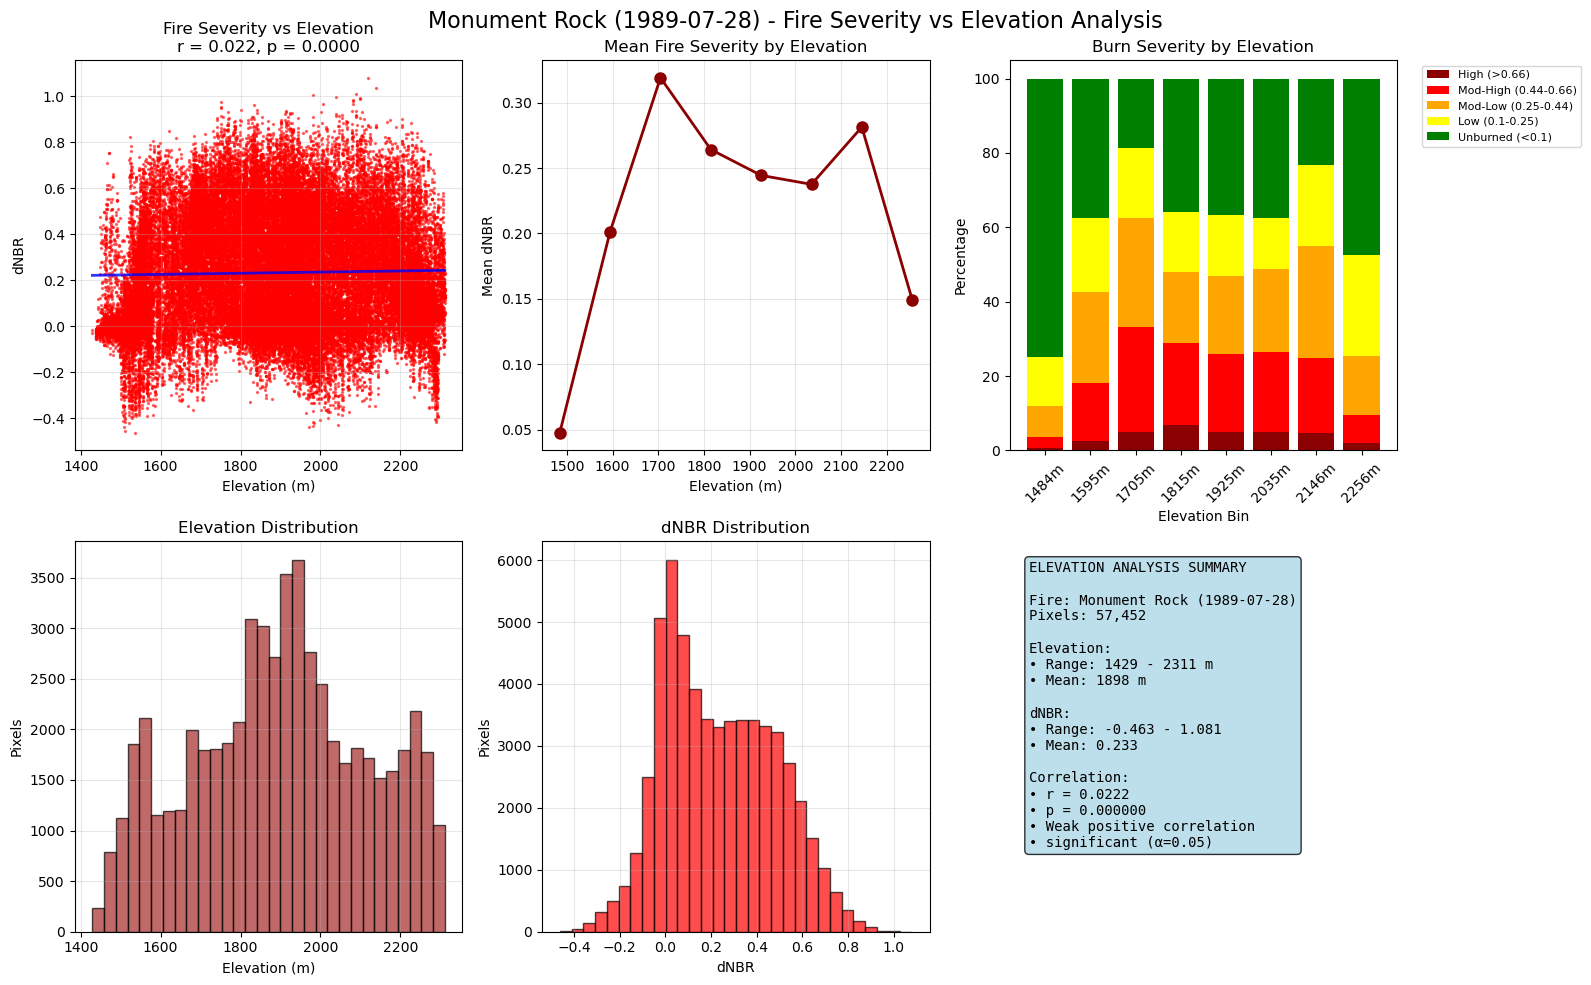

{'fire_info': {'name': 'Monument Rock',
  'id': '1989-ORWWF-000377',
  'year': 1989,
  'fire_date': Timestamp('1989-07-28 00:00:00'),
  'geometry': <POLYGON ((-118.255 44.33, -118.255 44.33, -118.255 44.33, -118.255 44.33, -...>},
 'analysis_dates': {'pre_fire': Timestamp('1989-06-28 00:00:00'),
  'post_fire': Timestamp('1990-07-28 00:00:00')},
 'pre_fire_nbr': <xarray.DataArray (band: 1, y: 362, x: 268)> Size: 776kB
 dask.array<getitem, shape=(1, 362, 268), dtype=float64, chunksize=(1, 362, 213), chunktype=numpy.ndarray>
 Coordinates:
   * band         (band) int64 8B 1
   * x            (x) float64 2kB 3.948e+05 3.949e+05 ... 4.028e+05 4.028e+05
   * y            (y) float64 3kB 4.916e+06 4.916e+06 ... 4.905e+06 4.905e+06
     spatial_ref  int64 8B 0,
 'post_fire_nbr': <xarray.DataArray (band: 1, y: 362, x: 268)> Size: 776kB
 dask.array<getitem, shape=(1, 362, 268), dtype=float64, chunksize=(1, 362, 175), chunktype=numpy.ndarray>
 Coordinates:
   * band         (band) int64 8B 1
   *

In [18]:
run_fire_elevation_analysis_by_date('Monument Rock', '1989-07-28')

### Module

In [9]:
import geopandas as gpd
import pandas as pd
import numpy as np
import rioxarray as rxr
import pystac_client
import planetary_computer as pc
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import requests
import time
import warnings
warnings.filterwarnings('ignore')

def clean_year(year_val):
    """Convert messy year data to clean integers"""
    if pd.isna(year_val):
        return None
    year_str = str(year_val)
    if '-' in year_str:
        return int(year_str.split('-')[0])
    return int(float(year_str))

def find_fire(fire_name, fire_file="../subsetted_data/mnf_fires_all.geojson"):
    """Find a fire by name in the dataset"""
    print(f"Looking for fire: {fire_name}")
    
    # Load fires
    fires = gpd.read_file(fire_file)
    fires['year'] = fires['FIRE_YEAR'].apply(clean_year)
    fires = fires.dropna(subset=['year']).to_crs('EPSG:4326')
    
    # Search
    matches = fires[fires['INCIDENT'].str.contains(fire_name, case=False, na=False)]
    
    if len(matches) == 0:
        print(f"No fires found with '{fire_name}' in the name")
        return None
    
    if len(matches) > 1:
        print(f"Found {len(matches)} matches:")
        for i, fire in matches.iterrows():
            print(f"  {fire['INCIDENT']} ({int(fire['year'])})")
    
    fire = matches.iloc[0]
    print(f"Using: {fire['INCIDENT']} ({int(fire['year'])})")
    return fire

def get_landsat_images(fire_polygon, target_date, days=30):
    """Get Landsat 5 images around a target date"""
    start = (target_date - timedelta(days=days)).strftime('%Y-%m-%d')
    end = (target_date + timedelta(days=days)).strftime('%Y-%m-%d')
    
    print(f"Searching Landsat 5 from {start} to {end}")
    
    catalog = pystac_client.Client.open(
        "https://planetarycomputer.microsoft.com/api/stac/v1/",
        modifier=pc.sign_inplace
    )
    
    search = catalog.search(
        collections=["landsat-c2-l2"],
        intersects=fire_polygon.__geo_interface__,
        datetime=f"{start}/{end}",
        query={"platform": {"in": ["landsat-5"]}}
    )
    
    items = list(search.items())
    
    if len(items) == 0:
        print("No images found")
        return []
    
    # Sort by cloud cover
    items_sorted = []
    for item in items:
        clouds = item.properties.get('eo:cloud_cover', 100)
        date = pd.to_datetime(item.properties['datetime']).strftime('%Y-%m-%d')
        items_sorted.append((item, clouds, date))
    
    items_sorted.sort(key=lambda x: x[1])  # Sort by cloud cover
    
    print(f"Found {len(items_sorted)} images:")
    for i, (item, clouds, date) in enumerate(items_sorted[:3]):
        print(f"  {i+1}: {date}, {clouds:.1f}% clouds")
    
    return [item for item, _, _ in items_sorted]

def calculate_nbr(landsat_item, fire_polygon):
    """Calculate NBR from Landsat bands"""
    signed_item = pc.sign(landsat_item)
    
    date = landsat_item.properties.get('datetime', 'Unknown')
    clouds = landsat_item.properties.get('eo:cloud_cover', 'Unknown')
    print(f"Processing: {date}, {clouds}% clouds")
    
    # Find the right band names (they vary)
    available_bands = list(signed_item.assets.keys())
    print(f"Available bands: {available_bands}")
    
    # Look for NIR and SWIR bands
    nir_band = None
    swir_band = None
    
    for band in available_bands:
        if band in ['B04', 'nir08']:
            nir_band = band
        elif band in ['B07', 'swir22']:
            swir_band = band
    
    if nir_band is None or swir_band is None:
        print(f"ERROR: Can't find NIR ({nir_band}) or SWIR ({swir_band}) bands")
        return None
    
    print(f"Using {nir_band} (NIR) and {swir_band} (SWIR)")
    
    # Load NIR and SWIR bands
    nir = rxr.open_rasterio(signed_item.assets[nir_band].href)
    swir = rxr.open_rasterio(signed_item.assets[swir_band].href)
    
    # Convert fire to raster CRS and buffer it
    fire_gdf = gpd.GeoDataFrame([1], geometry=[fire_polygon], crs='EPSG:4326')
    fire_proj = fire_gdf.to_crs(nir.rio.crs).geometry.iloc[0]
    fire_buffered = fire_proj.buffer(2000)  # 2km buffer
    
    # Crop to fire area
    nir_crop = nir.rio.clip([fire_buffered], drop=True)
    swir_crop = swir.rio.clip([fire_buffered], drop=True)
    
    # Scale to reflectance (Landsat Collection 2)
    nir_refl = nir_crop * 0.0000275 - 0.2
    swir_refl = swir_crop * 0.0000275 - 0.2
    
    # Calculate NBR
    nbr = (nir_refl - swir_refl) / (nir_refl + swir_refl)
    
    # Clip to exact fire boundary
    nbr_fire = nbr.rio.clip([fire_proj], drop=True)
    
    print(f"NBR calculated, shape: {nbr_fire.shape}")
    return nbr_fire

def get_burn_severity_stats(dnbr_values):
    """Calculate burn severity statistics"""
    high = np.sum(dnbr_values > 0.66)
    mod_high = np.sum((dnbr_values >= 0.44) & (dnbr_values <= 0.66))
    mod_low = np.sum((dnbr_values >= 0.25) & (dnbr_values < 0.44))
    low = np.sum((dnbr_values >= 0.1) & (dnbr_values < 0.25))
    unburned = np.sum(dnbr_values < 0.1)
    total = len(dnbr_values)
    
    return {
        'high': (high, 100 * high / total),
        'mod_high': (mod_high, 100 * mod_high / total),
        'mod_low': (mod_low, 100 * mod_low / total),
        'low': (low, 100 * low / total),
        'unburned': (unburned, 100 * unburned / total),
        'total': total
    }

def get_elevation_points(fire_polygon, n_points=400):
    """Get elevation data using OpenTopoData API"""
    print("Getting elevation data...")
    
    # Get fire bounds with buffer
    fire_gdf = gpd.GeoDataFrame([1], geometry=[fire_polygon], crs='EPSG:4326')
    fire_utm = fire_gdf.to_crs('EPSG:3857')
    buffered = fire_utm.buffer(3000).to_crs('EPSG:4326')  # 3km buffer
    bounds = buffered.bounds.iloc[0]
    
    # Create grid of points
    n_side = int(np.sqrt(n_points))
    lats = np.linspace(bounds[1], bounds[3], n_side)
    lons = np.linspace(bounds[0], bounds[2], n_side)
    
    elevations = []
    coords = []
    
    for lat in lats:
        for lon in lons:
            try:
                url = f"https://api.opentopodata.org/v1/srtm30m?locations={lat},{lon}"
                response = requests.get(url, timeout=5)
                
                if response.status_code == 200:
                    data = response.json()
                    if data['status'] == 'OK' and len(data['results']) > 0:
                        elev = data['results'][0]['elevation']
                        if elev is not None:
                            elevations.append(elev)
                            coords.append((lon, lat))
                
                time.sleep(0.05)  # Be nice to the API
                
            except:
                continue
    
    print(f"Got {len(elevations)} elevation points")
    
    if len(elevations) < 50:
        print("Not enough elevation data")
        return None
    
    # Simple interpolation to create a grid
    from scipy.interpolate import griddata
    
    target_lats = np.linspace(bounds[1], bounds[3], 100)
    target_lons = np.linspace(bounds[0], bounds[2], 100)
    lon_grid, lat_grid = np.meshgrid(target_lons, target_lats)
    
    elev_grid = griddata(coords, elevations, (lon_grid, lat_grid), method='cubic')
    
    # Fill missing values
    if np.isnan(elev_grid).any():
        elev_grid_nn = griddata(coords, elevations, (lon_grid, lat_grid), method='nearest')
        elev_grid = np.where(np.isnan(elev_grid), elev_grid_nn, elev_grid)
    
    # Convert to xarray
    import xarray as xr
    elevation = xr.DataArray(
        elev_grid,
        coords={'y': target_lats, 'x': target_lons},
        dims=['y', 'x']
    ).rio.write_crs('EPSG:4326')
    
    print(f"Elevation range: {float(elevation.min()):.0f} - {float(elevation.max()):.0f} m")
    return elevation

def analyze_elevation_vs_severity(dnbr, elevation, fire_polygon):
    """Correlate fire severity with elevation"""
    print("Analyzing elevation vs severity...")
    
    # Make sure both datasets match
    if dnbr.rio.crs != elevation.rio.crs:
        elevation = elevation.rio.reproject_match(dnbr)
    
    # Clip both to fire boundary
    fire_gdf = gpd.GeoDataFrame([1], geometry=[fire_polygon], crs='EPSG:4326')
    fire_proj = fire_gdf.to_crs(dnbr.rio.crs)
    
    dnbr_fire = dnbr.rio.clip(fire_proj.geometry, drop=True)
    elev_fire = elevation.rio.clip(fire_proj.geometry, drop=True)
    
    # Match shapes
    if dnbr_fire.shape != elev_fire.shape:
        elev_fire = elev_fire.rio.reproject_match(dnbr_fire)
    
    # Get clean data
    dnbr_flat = dnbr_fire.values.flatten()
    elev_flat = elev_fire.values.flatten()
    
    # Remove NaN values
    valid = ~(np.isnan(dnbr_flat) | np.isnan(elev_flat))
    dnbr_clean = dnbr_flat[valid]
    elev_clean = elev_flat[valid]
    
    print(f"Analyzing {len(dnbr_clean)} pixels")
    
    # Calculate correlation
    from scipy.stats import pearsonr
    correlation, p_value = pearsonr(dnbr_clean, elev_clean)
    
    # Bin by elevation
    n_bins = 6
    elev_bins = np.linspace(elev_clean.min(), elev_clean.max(), n_bins + 1)
    bin_centers = (elev_bins[:-1] + elev_bins[1:]) / 2
    
    severity_by_elev = []
    for i in range(n_bins):
        in_bin = (elev_clean >= elev_bins[i]) & (elev_clean < elev_bins[i + 1])
        if i == n_bins - 1:  # Include max value in last bin
            in_bin = (elev_clean >= elev_bins[i]) & (elev_clean <= elev_bins[i + 1])
        
        if np.sum(in_bin) > 0:
            bin_dnbr = dnbr_clean[in_bin]
            
            # Calculate all severity categories
            high_sev = 100 * np.sum(bin_dnbr > 0.66) / len(bin_dnbr)
            mod_high_sev = 100 * np.sum((bin_dnbr >= 0.44) & (bin_dnbr <= 0.66)) / len(bin_dnbr)
            mod_low_sev = 100 * np.sum((bin_dnbr >= 0.25) & (bin_dnbr < 0.44)) / len(bin_dnbr)
            low_sev = 100 * np.sum((bin_dnbr >= 0.1) & (bin_dnbr < 0.25)) / len(bin_dnbr)
            unburned = 100 * np.sum(bin_dnbr < 0.1) / len(bin_dnbr)
            
            severity_by_elev.append({
                'elevation': bin_centers[i],
                'mean_dnbr': np.mean(bin_dnbr),
                'high_severity': high_sev,
                'moderate_high': mod_high_sev,
                'moderate_low': mod_low_sev,
                'low_severity': low_sev,
                'unburned': unburned,
                'pixels': len(bin_dnbr)
            })
    
    return {
        'dnbr': dnbr_clean,
        'elevation': elev_clean,
        'correlation': correlation,
        'p_value': p_value,
        'elevation_bins': pd.DataFrame(severity_by_elev)
    }

def plot_results(results, fire_name):
    """Make comprehensive plots like the original"""
    fig = plt.figure(figsize=(16, 10))
    
    # Scatter plot with trend line
    ax1 = plt.subplot(2, 3, 1)
    plt.scatter(results['elevation'], results['dnbr'], alpha=0.5, s=2, c='red')
    
    z = np.polyfit(results['elevation'], results['dnbr'], 1)
    p = np.poly1d(z)
    x_trend = np.linspace(results['elevation'].min(), results['elevation'].max(), 100)
    plt.plot(x_trend, p(x_trend), 'blue', linewidth=2, alpha=0.8)
    
    plt.xlabel('Elevation (m)')
    plt.ylabel('dNBR')
    plt.title(f'Fire Severity vs Elevation\nr = {results["correlation"]:.3f}, p = {results["p_value"]:.4f}')
    plt.grid(True, alpha=0.3)
    
    # Mean dNBR by elevation
    ax2 = plt.subplot(2, 3, 2)
    bins = results['elevation_bins']
    plt.plot(bins['elevation'], bins['mean_dnbr'], 'o-', linewidth=2, markersize=8, color='darkred')
    plt.xlabel('Elevation (m)')
    plt.ylabel('Mean dNBR')
    plt.title('Mean Fire Severity by Elevation')
    plt.grid(True, alpha=0.3)
    
    # Stacked bar chart of ALL severity categories by elevation
    ax3 = plt.subplot(2, 3, 3)
    x_pos = np.arange(len(bins))
    
    # Get all severity percentages
    high_pct = bins['high_severity']
    mod_high_pct = bins['moderate_high']
    mod_low_pct = bins['moderate_low']
    low_pct = bins['low_severity']
    unburned_pct = bins['unburned']
    
    # Create stacked bars with all categories
    plt.bar(x_pos, high_pct, label='High (>0.66)', color='darkred')
    plt.bar(x_pos, mod_high_pct, bottom=high_pct, label='Mod-High (0.44-0.66)', color='red')
    plt.bar(x_pos, mod_low_pct, bottom=high_pct + mod_high_pct, label='Mod-Low (0.25-0.44)', color='orange')
    plt.bar(x_pos, low_pct, bottom=high_pct + mod_high_pct + mod_low_pct, label='Low (0.1-0.25)', color='yellow')
    plt.bar(x_pos, unburned_pct, bottom=high_pct + mod_high_pct + mod_low_pct + low_pct, label='Unburned (<0.1)', color='green')
    
    plt.xlabel('Elevation Bin')
    plt.ylabel('Percentage')
    plt.title('Burn Severity by Elevation')
    plt.xticks(x_pos, [f"{elev:.0f}m" for elev in bins['elevation']], rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    
    # Elevation histogram
    ax4 = plt.subplot(2, 3, 4)
    plt.hist(results['elevation'], bins=30, alpha=0.7, color='brown', edgecolor='black')
    plt.xlabel('Elevation (m)')
    plt.ylabel('Pixels')
    plt.title('Elevation Distribution')
    plt.grid(True, alpha=0.3)
    
    # dNBR histogram
    ax5 = plt.subplot(2, 3, 5)
    plt.hist(results['dnbr'], bins=30, alpha=0.7, color='red', edgecolor='black')
    plt.xlabel('dNBR')
    plt.ylabel('Pixels')
    plt.title('dNBR Distribution')
    plt.grid(True, alpha=0.3)
    
    # Summary statistics box
    ax6 = plt.subplot(2, 3, 6)
    ax6.axis('off')
    
    corr_abs = abs(results['correlation'])
    strength = "Strong" if corr_abs > 0.7 else "Moderate" if corr_abs > 0.3 else "Weak"
    direction = "positive" if results['correlation'] > 0 else "negative"
    significance = "significant" if results['p_value'] < 0.05 else "not significant"
    
    summary_text = f"""ELEVATION ANALYSIS SUMMARY

Fire: {fire_name}
Pixels: {len(results['dnbr']):,}

Elevation:
• Range: {results['elevation'].min():.0f} - {results['elevation'].max():.0f} m
• Mean: {results['elevation'].mean():.0f} m

dNBR:
• Range: {results['dnbr'].min():.3f} - {results['dnbr'].max():.3f}
• Mean: {results['dnbr'].mean():.3f}

Correlation:
• r = {results['correlation']:.4f}
• p = {results['p_value']:.6f}
• {strength} {direction} correlation
• {significance} (α=0.05)"""
    
    ax6.text(0.05, 0.95, summary_text, transform=ax6.transAxes, fontsize=10,
             verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    
    plt.suptitle(f'{fire_name} - Fire Severity vs Elevation Analysis', fontsize=16, y=0.98)
    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    plt.show()

def analyze_fire(fire_name, fire_date, fire_file="../subsetted_data/mnf_fires_all.geojson"):
    """
    Main function - analyze a fire by name and date
    
    Example: analyze_fire("Canyon Creek", "1989-08-04")
    """
    print(f"FIRE ANALYSIS: {fire_name}")
    
    # Find the fire
    fire = find_fire(fire_name, fire_file)
    if fire is None:
        return None
    
    # Set up dates
    fire_date = pd.to_datetime(fire_date)
    pre_fire_date = fire_date - timedelta(days=30)
    post_fire_date = fire_date + timedelta(days=365)
    
    print(f"Dates:")
    print(f"  Fire: {fire_date.strftime('%Y-%m-%d')}")
    print(f"  Pre-fire search: {pre_fire_date.strftime('%Y-%m-%d')}")
    print(f"  Post-fire search: {post_fire_date.strftime('%Y-%m-%d')}")
    
    # Get satellite images
    print(f"Getting pre-fire imagery...")
    pre_images = get_landsat_images(fire.geometry, pre_fire_date)
    if len(pre_images) == 0:
        return None
    
    print(f"Getting post-fire imagery...")
    post_images = get_landsat_images(fire.geometry, post_fire_date)
    if len(post_images) == 0:
        return None
    
    # Calculate NBR
    print(f"Calculating pre-fire NBR...")
    pre_nbr = calculate_nbr(pre_images[0], fire.geometry)
    
    print(f"Calculating post-fire NBR...")
    post_nbr = calculate_nbr(post_images[0], fire.geometry)
    
    # Calculate dNBR
    print(f"Calculating dNBR...")
    if pre_nbr.rio.crs != post_nbr.rio.crs:
        post_nbr = post_nbr.rio.reproject_match(pre_nbr)
    
    dnbr = pre_nbr - post_nbr
    dnbr_values = dnbr.values.flatten()
    dnbr_clean = dnbr_values[~np.isnan(dnbr_values)]
    
    print(f"dNBR stats: mean={np.mean(dnbr_clean):.3f}, range={np.min(dnbr_clean):.3f} to {np.max(dnbr_clean):.3f}")
    
    # Burn severity stats
    severity = get_burn_severity_stats(dnbr_clean)
    print(f"Burn Severity ({severity['total']} pixels):")
    print(f"  High (>0.66):       {severity['high'][0]:4d} ({severity['high'][1]:4.1f}%)")
    print(f"  Moderate-High:      {severity['mod_high'][0]:4d} ({severity['mod_high'][1]:4.1f}%)")
    print(f"  Moderate-Low:       {severity['mod_low'][0]:4d} ({severity['mod_low'][1]:4.1f}%)")
    print(f"  Low (0.1-0.25):     {severity['low'][0]:4d} ({severity['low'][1]:4.1f}%)")
    print(f"  Unburned (<0.1):    {severity['unburned'][0]:4d} ({severity['unburned'][1]:4.1f}%)")
    
    # Get elevation data
    print(f"Getting elevation data...")
    elevation = get_elevation_points(fire.geometry)
    if elevation is None:
        print("Skipping elevation analysis")
        return {'fire': fire, 'dnbr': dnbr, 'severity': severity}
    
    # Elevation analysis
    print(f"Analyzing elevation vs severity...")
    elev_results = analyze_elevation_vs_severity(dnbr, elevation, fire.geometry)
    
    # Print detailed results
    print("======================================================================")
    print("FIRE SEVERITY + ELEVATION ANALYSIS RESULTS")
    print("======================================================================")
    
    print(f"Fire Information:")
    print(f"Name: {fire['INCIDENT']}")
    print(f"ID: {fire.get('UNQE_FIRE_', 'Unknown')}")
    print(f"Year: {int(fire['year'])}")
    print(f"Fire Date: {fire_date.strftime('%Y-%m-%d')}")
    print(f"Satellite: Landsat 5 (30m resolution)")
    
    print(f"Spatial Analysis:")
    print(f"Total analyzed pixels: {len(elev_results['dnbr']):,}")
    print(f"Fire area: {fire.geometry.area:.8f} square degrees")
    
    print(f"Elevation Summary:")
    print(f"Range: {elev_results['elevation'].min():.0f} - {elev_results['elevation'].max():.0f} m")
    print(f"Mean: {elev_results['elevation'].mean():.0f} m")
    print(f"Relief: {elev_results['elevation'].max() - elev_results['elevation'].min():.0f} m")
    
    print(f"Fire Severity Summary:")
    print(f"dNBR Range: {elev_results['dnbr'].min():.3f} - {elev_results['dnbr'].max():.3f}")
    print(f"Mean dNBR: {elev_results['dnbr'].mean():.3f}")
    
    print(f"Elevation-Fire Severity Correlation:")
    print(f"Pearson correlation: {elev_results['correlation']:.4f}")
    print(f"P-value: {elev_results['p_value']:.6f}")
    print(f"Statistical significance: {'Yes' if elev_results['p_value'] < 0.05 else 'No'} (α=0.05)")
    
    # Interpretation
    corr_abs = abs(elev_results['correlation'])
    if corr_abs > 0.3:
        strength = "strong" if corr_abs > 0.7 else "moderate"
    else:
        strength = "weak"
    
    direction = "positive" if elev_results['correlation'] > 0 else "negative"
    
    print(f"Interpretation:")
    print(f"There is a {strength} {direction} correlation between elevation and fire severity.")
    
    if elev_results['correlation'] > 0.1:
        print(f"Higher elevations experienced more severe burning on average.")
    elif elev_results['correlation'] < -0.1:
        print(f"Lower elevations experienced more severe burning on average.")
    else:
        print(f"Elevation does not strongly influence fire severity in this fire.")
    
    # Elevation-based severity table
    bins_df = elev_results['elevation_bins']
    print(f"Detailed Severity by Elevation Zones:")
    print(f"{'Elevation (m)':<12} {'Mean dNBR':<10} {'High Sev %':<11} {'Mod-High %':<11} {'Pixels':<8}")
    print("------------------------------------------------------------------")
    for _, row in bins_df.iterrows():
        print(f"{row['elevation']:<12.0f} {row['mean_dnbr']:<10.3f} "
              f"{row['high_severity']:<11.1f} {row['moderate_high']:<11.1f} {row['pixels']:<8.0f}")
    
    # Make plots
    print(f"Creating plots...")
    plot_results(elev_results, f"{fire['INCIDENT']} ({fire_date.strftime('%Y')})")
    
    print(f"Analysis complete!")
    
    return {
        'fire': fire,
        'dnbr': dnbr,
        'elevation': elevation,
        'severity': severity,
        'elevation_analysis': elev_results
    }

def run_fire_elevation_analysis_by_date(fire_name, fire_date, fire_file="../subsetted_data/mnf_fires_all.geojson"):
    """
    Complete workflow function - matches the original function name
    
    Example: run_fire_elevation_analysis_by_date("Monument Rock", "1989-07-28")
    """
    return analyze_fire(fire_name, fire_date, fire_file)

# Simple usage examples
if __name__ == "__main__":
    print("Simple Fire Analysis")
    print("===================")
    print()
    print("Usage:")
    print("  results = run_fire_elevation_analysis_by_date('Monument Rock', '1989-07-28')")
    print("  results = run_fire_elevation_analysis_by_date('Canyon Creek', '1989-08-04')")
    print()
    print("The function will:")
    print("  1. Find your fire by name")
    print("  2. Get Landsat imagery before and after the fire")
    print("  3. Calculate burn severity (dNBR)")
    print("  4. Download elevation data")
    print("  5. Analyze how elevation affects fire severity")
    print("  6. Make plots")

Simple Fire Analysis

Usage:
  results = run_fire_elevation_analysis_by_date('Monument Rock', '1989-07-28')
  results = run_fire_elevation_analysis_by_date('Canyon Creek', '1989-08-04')

The function will:
  1. Find your fire by name
  2. Get Landsat imagery before and after the fire
  3. Calculate burn severity (dNBR)
  4. Download elevation data
  5. Analyze how elevation affects fire severity
  6. Make plots


FIRE ANALYSIS: Monument Rock
Looking for fire: Monument Rock
Using: Monument Rock (1989)
Dates:
  Fire: 1989-07-28
  Pre-fire search: 1989-06-28
  Post-fire search: 1990-07-28
Getting pre-fire imagery...
Searching Landsat 5 from 1989-05-29 to 1989-07-28
Found 2 images:
  1: 1989-07-28, 0.0% clouds
  2: 1989-06-10, 7.0% clouds
Getting post-fire imagery...
Searching Landsat 5 from 1990-06-28 to 1990-08-27
Found 1 images:
  1: 1990-08-16, 14.0% clouds
Calculating pre-fire NBR...
Processing: 1989-07-28T18:05:01.513094Z, 0.0% clouds
Available bands: ['qa', 'ang', 'red', 'blue', 'drad', 'emis', 'emsd', 'lwir', 'trad', 'urad', 'atran', 'cdist', 'green', 'nir08', 'swir16', 'swir22', 'mtl.txt', 'mtl.xml', 'cloud_qa', 'mtl.json', 'qa_pixel', 'qa_radsat', 'atmos_opacity', 'tilejson', 'rendered_preview']
Using nir08 (NIR) and swir22 (SWIR)
NBR calculated, shape: (1, 360, 267)
Calculating post-fire NBR...
Processing: 1990-08-16T17:57:51.912000Z, 14.0% clouds
Available bands: ['qa', 'ang', 'red', 'b

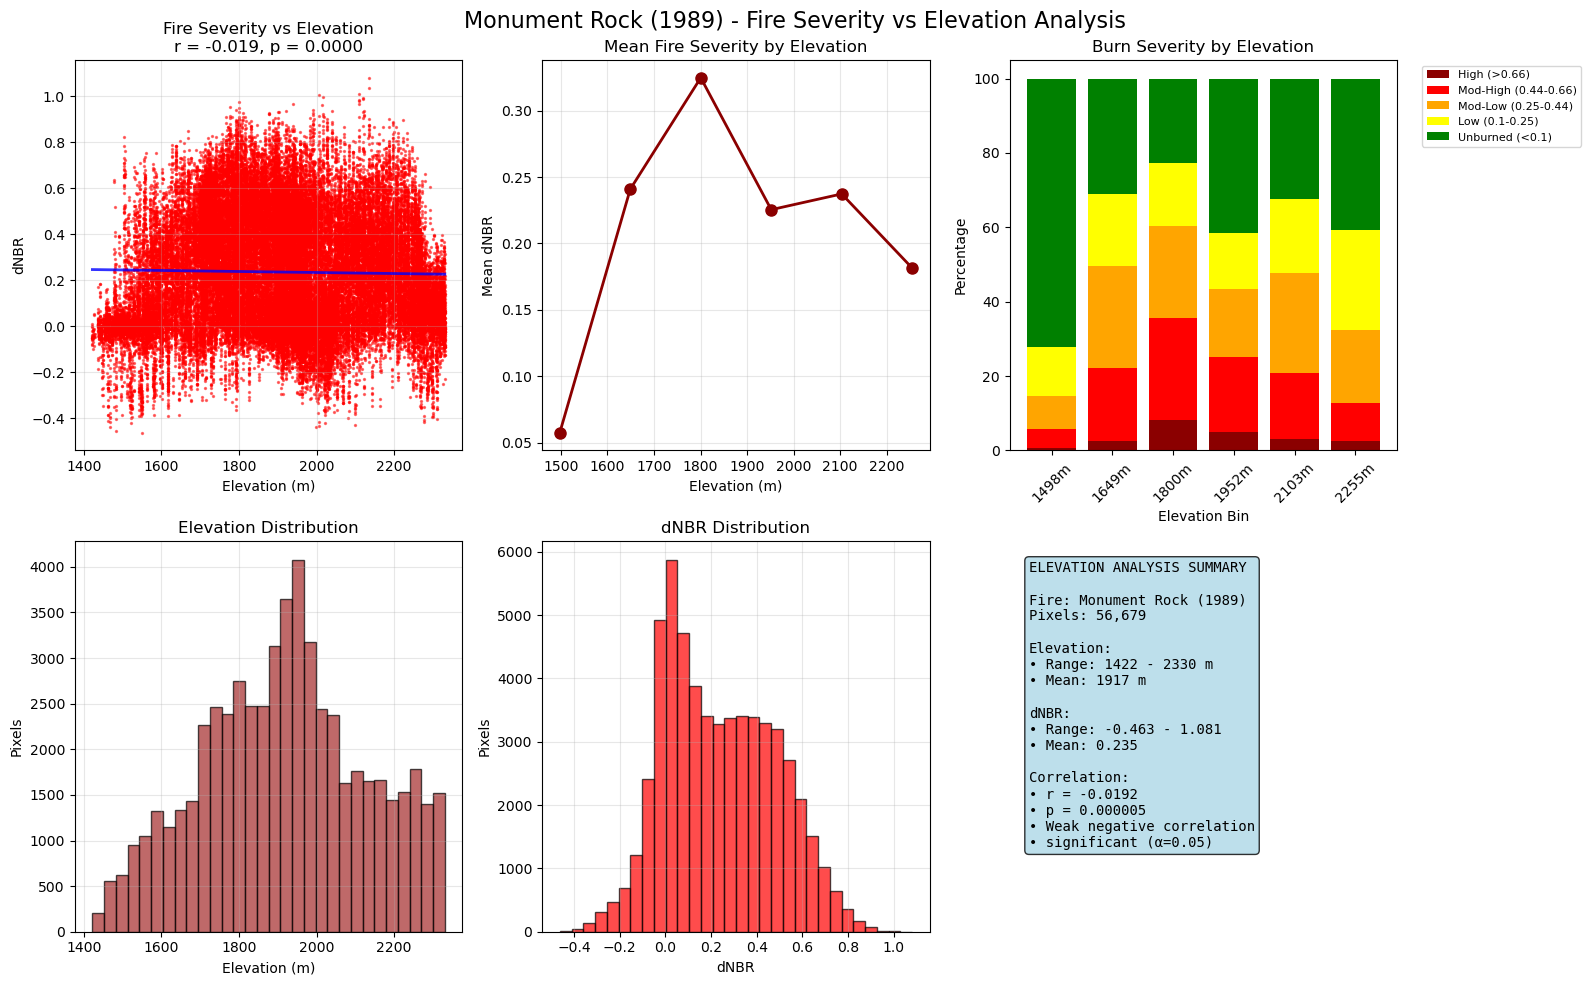

Analysis complete!


In [10]:
analyze_fire('Monument Rock', '1989-07-28');

In [7]:
run_fire_elevation_analysis_by_date('Monument Rock', '1989-07-28');

FIRE ANALYSIS: Monument Rock
Using: Monument Rock (1989)
Dates:
  Fire: 1989-07-28
  Pre-fire search: 1989-06-28
  Post-fire search: 1990-07-28
Getting pre-fire imagery...
Searching Landsat 5 from 1989-05-29 to 1989-06-28
Found 1 images:
  1: 1989-06-10, 7.0% clouds
Getting post-fire imagery...
Searching Landsat 5 from 1990-06-28 to 1990-08-27
Found 1 images:
  1: 1990-08-16, 14.0% clouds
Calculating pre-fire NBR...
Processing: 1989-06-10T18:05:58.307000Z, 7.0% clouds
Using nir08 (NIR) and swir22 (SWIR)
NBR calculated, shape: (1, 360, 267)
Calculating post-fire NBR...
Processing: 1990-08-16T17:57:51.912000Z, 14.0% clouds
Using nir08 (NIR) and swir22 (SWIR)
NBR calculated, shape: (1, 360, 267)
dNBR stats: mean=0.214, range=-0.468 to 0.967


FIRE SEVERITY + ELEVATION ANALYSIS BY DATE
Searching for fire data file...
Found fire data at: ../downloaded_data/mnf_fires_all.geojson
Loading fire data to find 'Monument Rock'...
Found: Monument Rock (1989)

Selected Fire: Monument Rock (1989-ORWWF-000377)
Fire Year: 1989
Fire Date: 1989-07-28
Fire Area: 0.00575968 square degrees

Analysis Timeline:
Fire date: 1989-07-28
Pre-fire target: 1989-07-14 (14 days before)
Post-fire target: 1990-07-28 (365 days after)
Satellite: LANDSAT-5

Searching for pre-fire imagery...
Attempt 1: Searching with +/-30 day buffer...
Searching LANDSAT-5 imagery from 1989-06-14 to 1989-08-13
Found 2 images
  Image 1: 1989-07-28, 0.0% clouds, 14 days from target
  Image 2: 1989-08-13, 0.0% clouds, 30 days from target

Calculating pre-fire NBR...
Processing LANDSAT-5 image from: 1989-07-28T18:05:01.513094Z
Cloud cover: 0.0%
Using NIR: nir08, SWIR2: swir22
Valid pixels: 57452/97016 (59.2%)
NBR calculated successfully
Pre-fire NBR: Mean 0.318

Searching for post

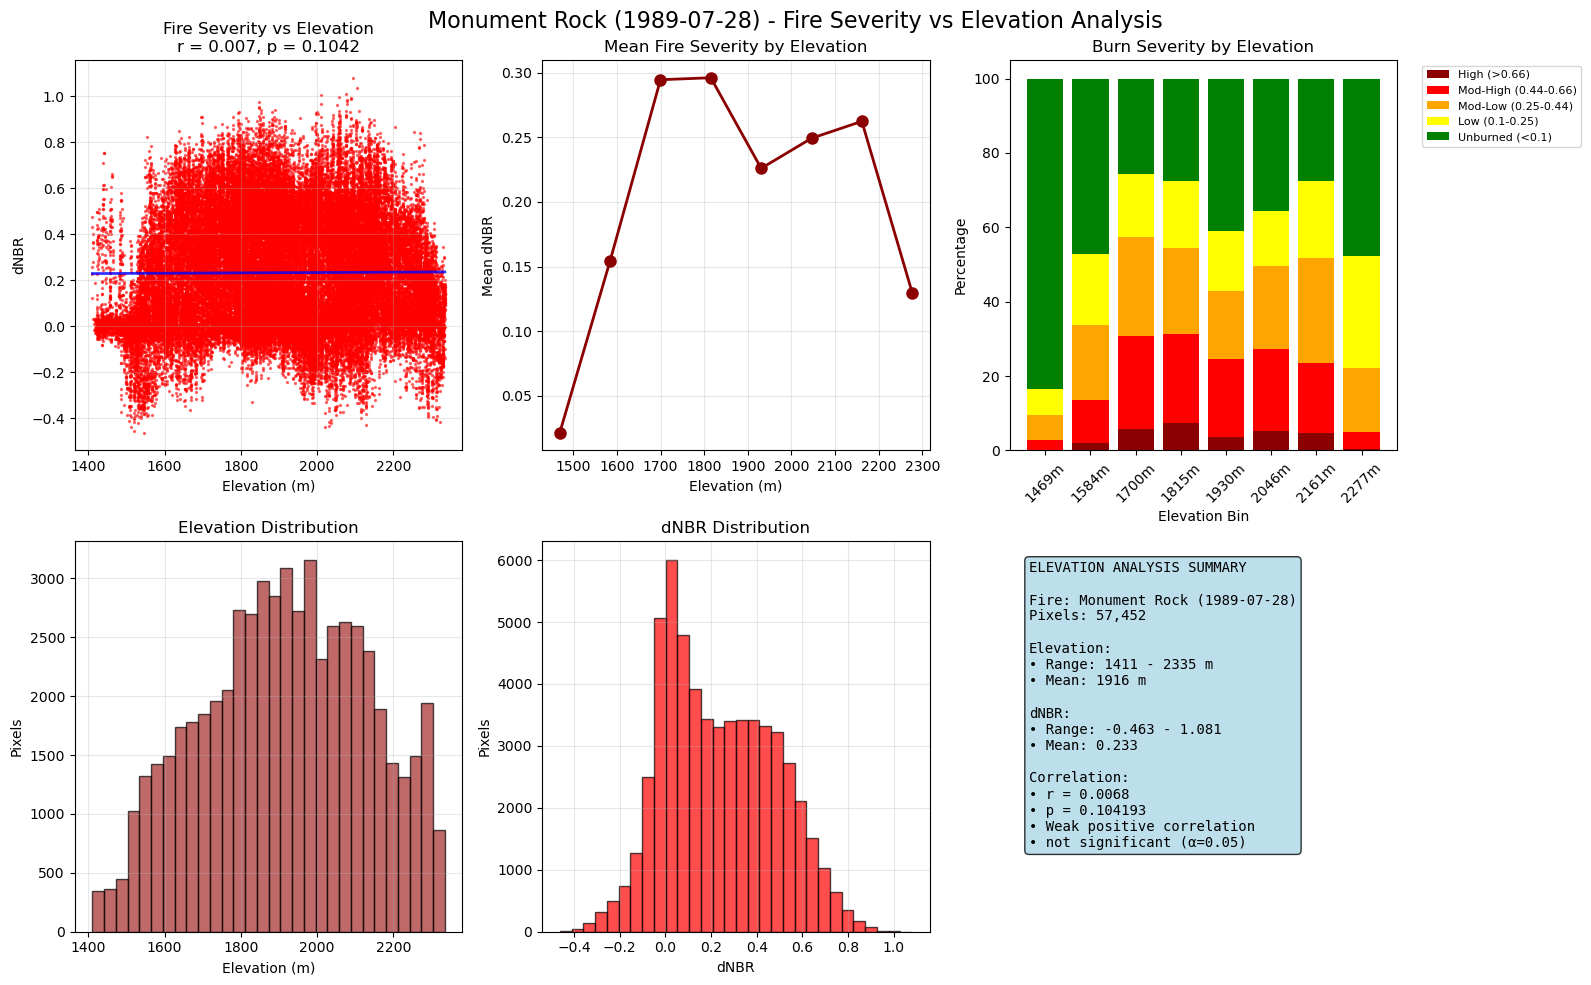


FINAL ANALYSIS RESULTS

Fire Information:
Name: Monument Rock
ID: 1989-ORWWF-000377
Year: 1989
Fire Date: 1989-07-28
Satellite: LANDSAT-5

Analysis Dates:
Pre-fire imagery: 1989-07-14
Post-fire imagery: 1990-07-28

Spatial Analysis:
Total analyzed pixels: 57,452
Fire area: 0.00575968 square degrees

Elevation Summary:
Range: 1411 - 2335 m
Mean: 1916 m
Relief: 924 m

Fire Severity Summary:
dNBR Range: -0.463 - 1.081
Mean dNBR: 0.233

Elevation-Fire Severity Correlation:
Pearson correlation: 0.0068
P-value: 0.104193
Statistical significance: No (α=0.05)

Interpretation:
There is a weak positive correlation between elevation and fire severity.
Elevation does not strongly influence fire severity in this fire.

Detailed Severity by Elevation Zones:
Elevation (m) Mean dNBR  High Sev %  Mod-High %  Pixels  
-----------------------------------------------------------------
1469         0.022      0.2         2.7         1849    
1584         0.155      1.9         11.7        5459    
1700   

{'fire_info': {'geometry': <POLYGON ((-118.255 44.33, -118.255 44.33, -118.255 44.33, -118.255 44.33, -...>,
  'fire_id': '1989-ORWWF-000377',
  'incident_name': 'Monument Rock',
  'fire_year': 1989,
  'fire_date': Timestamp('1989-07-28 00:00:00')},
 'analysis_dates': {'pre_fire': Timestamp('1989-07-14 00:00:00'),
  'post_fire': Timestamp('1990-07-28 00:00:00')},
 'pre_fire_nbr': <xarray.DataArray (band: 1, y: 362, x: 268)> Size: 776kB
 dask.array<getitem, shape=(1, 362, 268), dtype=float64, chunksize=(1, 362, 213), chunktype=numpy.ndarray>
 Coordinates:
   * band         (band) int64 8B 1
   * x            (x) float64 2kB 3.948e+05 3.949e+05 ... 4.028e+05 4.028e+05
   * y            (y) float64 3kB 4.916e+06 4.916e+06 ... 4.905e+06 4.905e+06
     spatial_ref  int64 8B 0,
 'post_fire_nbr': <xarray.DataArray (band: 1, y: 362, x: 268)> Size: 776kB
 dask.array<getitem, shape=(1, 362, 268), dtype=float64, chunksize=(1, 362, 175), chunktype=numpy.ndarray>
 Coordinates:
   * band         (ba

In [2]:
run_fire_elevation_analysis_by_date('Monument Rock', '1989-07-28', pre_fire_days=14)

FIRE SEVERITY + ELEVATION ANALYSIS BY DATE
Searching for fire data file...
Found fire data at: ../downloaded_data/mnf_fires_all.geojson
Loading fire data to find 'Whiting Springs'...
Found: Whiting Springs (1990)

Selected Fire: Whiting Springs (1990-ORMAF-000064)
Fire Year: 1990
Fire Date: 1990-08-06
Fire Area: 0.00254401 square degrees

Analysis Timeline:
Fire date: 1990-08-06
Pre-fire target: 1990-07-23 (14 days before)
Post-fire target: 1991-08-06 (365 days after)
Satellite: LANDSAT-5

Searching for pre-fire imagery...
Attempt 1: Searching with +/-30 day buffer...
Searching LANDSAT-5 imagery from 1990-06-23 to 1990-08-22
Found 3 images
  Image 1: 1990-08-07, 7.0% clouds, 15 days from target
  Image 2: 1990-08-07, 17.0% clouds, 15 days from target
  Image 3: 1990-08-16, 16.0% clouds, 24 days from target

Calculating pre-fire NBR...
Processing LANDSAT-5 image from: 1990-08-07T18:04:04.885000Z
Cloud cover: 7.0%
Using NIR: nir08, SWIR2: swir22
Valid pixels: 25809/61771 (41.8%)
NBR calc

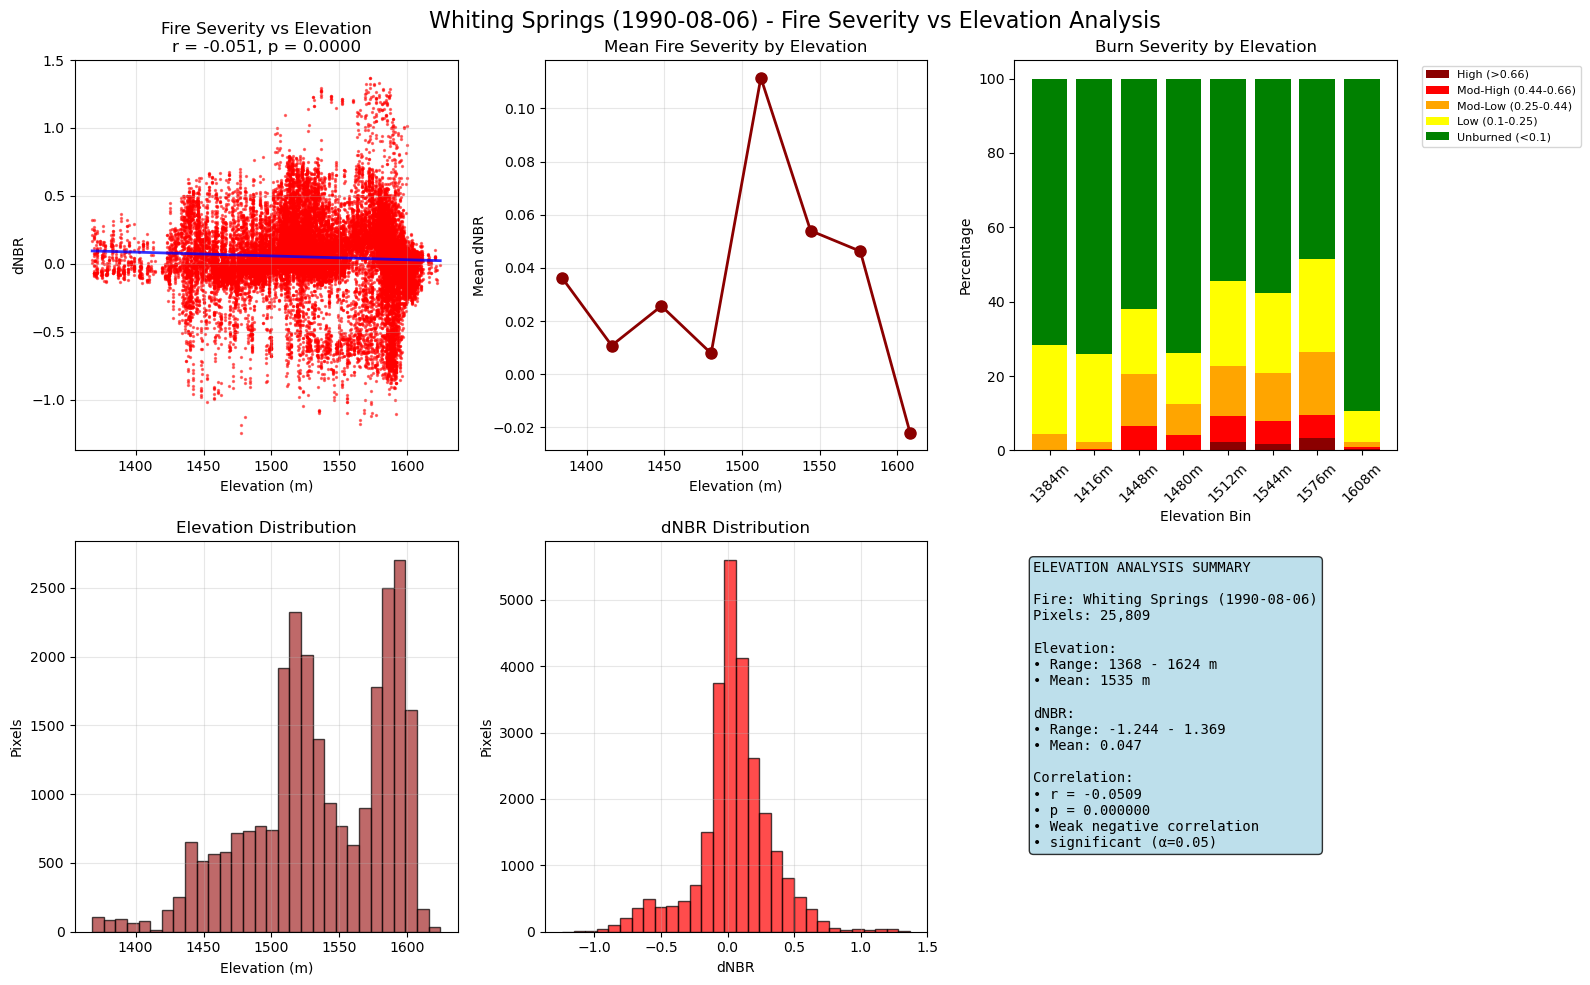


FINAL ANALYSIS RESULTS

Fire Information:
Name: Whiting Springs
ID: 1990-ORMAF-000064
Year: 1990
Fire Date: 1990-08-06
Satellite: LANDSAT-5

Analysis Dates:
Pre-fire imagery: 1990-07-23
Post-fire imagery: 1991-08-06

Spatial Analysis:
Total analyzed pixels: 25,809
Fire area: 0.00254401 square degrees

Elevation Summary:
Range: 1368 - 1624 m
Mean: 1535 m
Relief: 256 m

Fire Severity Summary:
dNBR Range: -1.244 - 1.369
Mean dNBR: 0.047

Elevation-Fire Severity Correlation:
Pearson correlation: -0.0509
P-value: 0.000000
Statistical significance: Yes (α=0.05)

Interpretation:
There is a weak negative correlation between elevation and fire severity.
Elevation does not strongly influence fire severity in this fire.

Detailed Severity by Elevation Zones:
Elevation (m) Mean dNBR  High Sev %  Mod-High %  Pixels  
-----------------------------------------------------------------
1384         0.036      0.0         0.0         348     
1416         0.011      0.0         0.3         365     
144

{'fire_info': {'geometry': <POLYGON ((-119.048 43.75, -119.061 43.75, -119.061 43.75, -119.061 43.75, -...>,
  'fire_id': '1990-ORMAF-000064',
  'incident_name': 'Whiting Springs',
  'fire_year': 1990,
  'fire_date': Timestamp('1990-08-06 00:00:00')},
 'analysis_dates': {'pre_fire': Timestamp('1990-07-23 00:00:00'),
  'post_fire': Timestamp('1991-08-06 00:00:00')},
 'pre_fire_nbr': <xarray.DataArray (band: 1, y: 277, x: 223)> Size: 494kB
 dask.array<getitem, shape=(1, 277, 223), dtype=float64, chunksize=(1, 277, 173), chunktype=numpy.ndarray>
 Coordinates:
   * band         (band) int64 8B 1
   * x            (x) float64 2kB 3.324e+05 3.325e+05 ... 3.391e+05 3.391e+05
   * y            (y) float64 2kB 4.854e+06 4.854e+06 ... 4.846e+06 4.846e+06
     spatial_ref  int64 8B 0,
 'post_fire_nbr': <xarray.DataArray (band: 1, y: 277, x: 223)> Size: 494kB
 dask.array<getitem, shape=(1, 277, 223), dtype=float64, chunksize=(1, 277, 223), chunktype=numpy.ndarray>
 Coordinates:
   * band         (

In [3]:
run_fire_elevation_analysis_by_date('Whiting Springs', '1990-08-06', pre_fire_days=14)

FIRE SEVERITY + ELEVATION ANALYSIS BY DATE
Searching for fire data file...
Found fire data at: ../downloaded_data/mnf_fires_all.geojson
Loading fire data to find 'Whiting Springs'...
Found: Whiting Springs (1990)

Selected Fire: Whiting Springs (1990-ORMAF-000064)
Fire Year: 1990
Fire Date: 1990-08-06
Fire Area: 0.00254401 square degrees

Analysis Timeline:
Fire date: 1990-08-06
Pre-fire target: 1990-07-23 (14 days before)
Post-fire target: 1991-08-06 (365 days after)
Satellite: LANDSAT-5

Searching for pre-fire imagery...
Attempt 1: Searching with +/-30 day buffer...
Searching LANDSAT-5 imagery from 1990-06-23 to 1990-08-22
Found 3 images
  Image 1: 1990-08-07, 7.0% clouds, 15 days from target
  Image 2: 1990-08-07, 17.0% clouds, 15 days from target
  Image 3: 1990-08-16, 16.0% clouds, 24 days from target

Calculating pre-fire NBR...
Processing LANDSAT-5 image from: 1990-08-07T18:04:04.885000Z
Cloud cover: 7.0%
Using NIR: nir08, SWIR2: swir22
Valid pixels: 25809/61771 (41.8%)
NBR calc

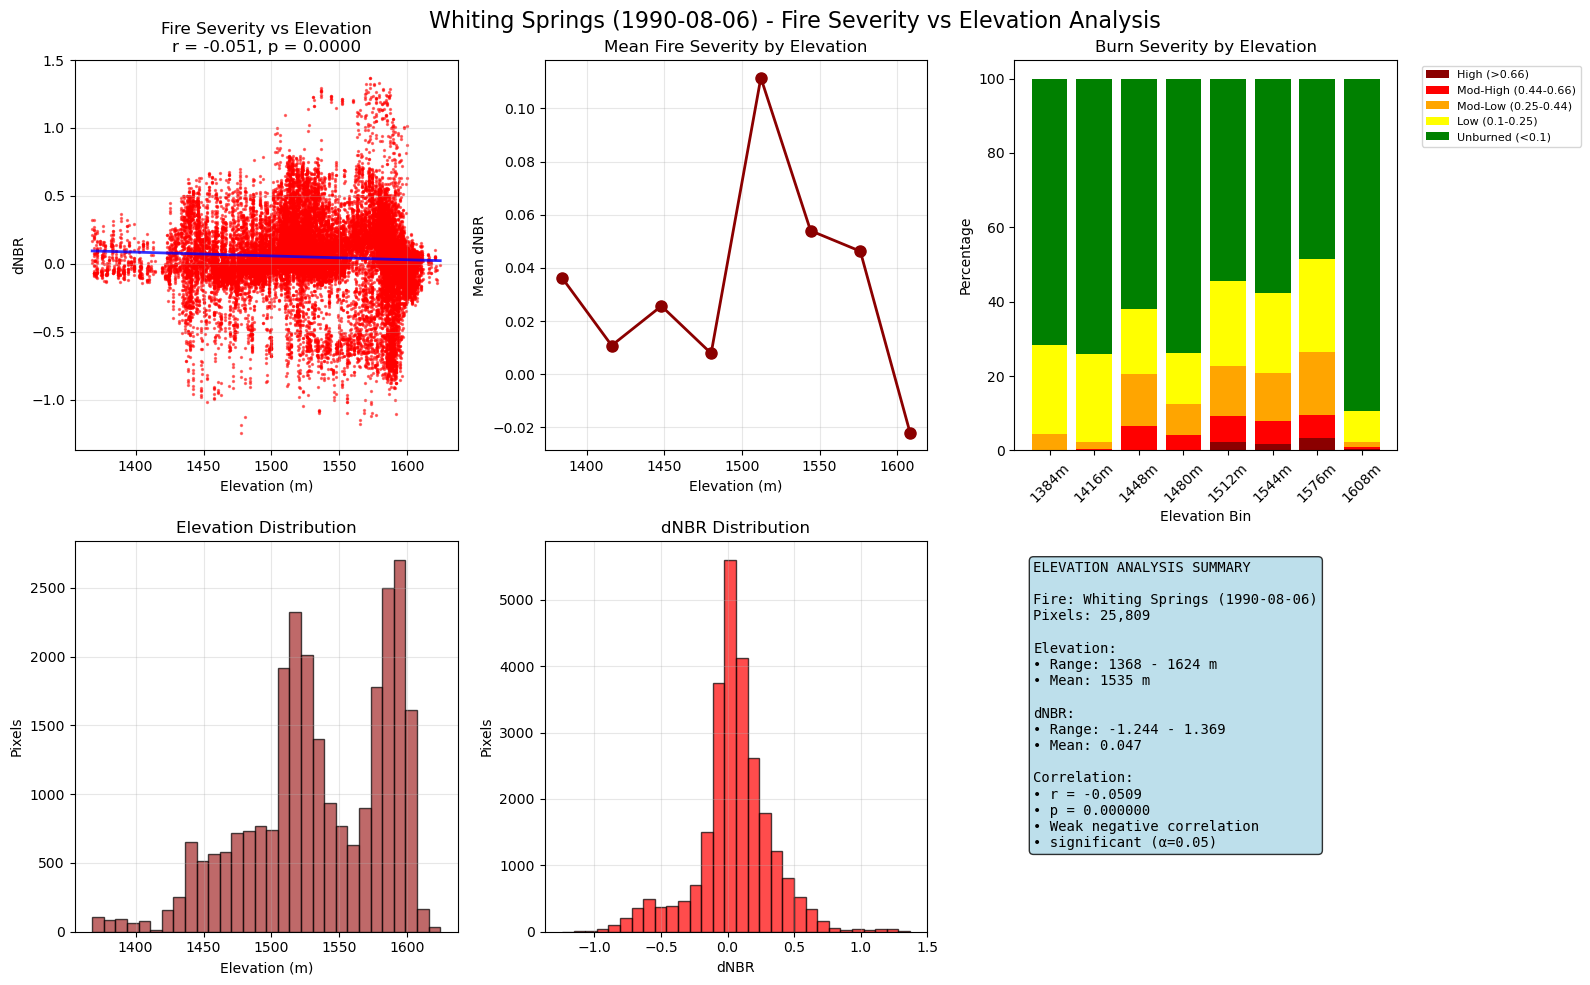


FINAL ANALYSIS RESULTS

Fire Information:
Name: Whiting Springs
ID: 1990-ORMAF-000064
Year: 1990
Fire Date: 1990-08-06
Satellite: LANDSAT-5

Analysis Dates:
Pre-fire imagery: 1990-07-23
Post-fire imagery: 1991-08-06

Spatial Analysis:
Total analyzed pixels: 25,809
Fire area: 0.00254401 square degrees

Elevation Summary:
Range: 1368 - 1624 m
Mean: 1535 m
Relief: 256 m

Fire Severity Summary:
dNBR Range: -1.244 - 1.369
Mean dNBR: 0.047

Elevation-Fire Severity Correlation:
Pearson correlation: -0.0509
P-value: 0.000000
Statistical significance: Yes (α=0.05)

Interpretation:
There is a weak negative correlation between elevation and fire severity.
Elevation does not strongly influence fire severity in this fire.

Detailed Severity by Elevation Zones:
Elevation (m) Mean dNBR  High Sev %  Mod-High %  Pixels  
-----------------------------------------------------------------
1384         0.036      0.0         0.0         348     
1416         0.011      0.0         0.3         365     
144

{'fire_info': {'geometry': <POLYGON ((-119.048 43.75, -119.061 43.75, -119.061 43.75, -119.061 43.75, -...>,
  'fire_id': '1990-ORMAF-000064',
  'incident_name': 'Whiting Springs',
  'fire_year': 1990,
  'fire_date': Timestamp('1990-08-06 00:00:00')},
 'analysis_dates': {'pre_fire': Timestamp('1990-07-23 00:00:00'),
  'post_fire': Timestamp('1991-08-06 00:00:00')},
 'pre_fire_nbr': <xarray.DataArray (band: 1, y: 277, x: 223)> Size: 494kB
 dask.array<getitem, shape=(1, 277, 223), dtype=float64, chunksize=(1, 277, 173), chunktype=numpy.ndarray>
 Coordinates:
   * band         (band) int64 8B 1
   * x            (x) float64 2kB 3.324e+05 3.325e+05 ... 3.391e+05 3.391e+05
   * y            (y) float64 2kB 4.854e+06 4.854e+06 ... 4.846e+06 4.846e+06
     spatial_ref  int64 8B 0,
 'post_fire_nbr': <xarray.DataArray (band: 1, y: 277, x: 223)> Size: 494kB
 dask.array<getitem, shape=(1, 277, 223), dtype=float64, chunksize=(1, 277, 223), chunktype=numpy.ndarray>
 Coordinates:
   * band         (

In [3]:
run_fire_elevation_analysis_by_date('Whiting Springs', '1990-08-06', pre_fire_days=14)

FIRE SEVERITY + ELEVATION ANALYSIS BY DATE
Searching for fire data file...
Found fire data at: ../downloaded_data/mnf_fires_all.geojson
Loading fire data to find 'Pine Springs'...
Found 2 fires matching 'Pine Springs':
  0: Pine Springs (1990) - 39946.1 ha - None
  1: Pine Springs Basin (1990) - 40737.5 ha - 1990-ORBUD-000000
Using: Pine Springs (1990)

Selected Fire: Pine Springs (None)
Fire Year: 1990
Fire Date: 1990-08-06
Fire Area: 0.03242116 square degrees

Analysis Timeline:
Fire date: 1990-08-06
Pre-fire target: 1990-07-23 (14 days before)
Post-fire target: 1991-08-06 (365 days after)
Satellite: LANDSAT-5

Searching for pre-fire imagery...
Attempt 1: Searching with +/-30 day buffer...
Searching LANDSAT-5 imagery from 1990-06-23 to 1990-08-22
Found 3 images
  Image 1: 1990-08-07, 7.0% clouds, 15 days from target
  Image 2: 1990-08-16, 16.0% clouds, 24 days from target
  Image 3: 1990-08-07, 17.0% clouds, 15 days from target

Calculating pre-fire NBR...
Processing LANDSAT-5 image 

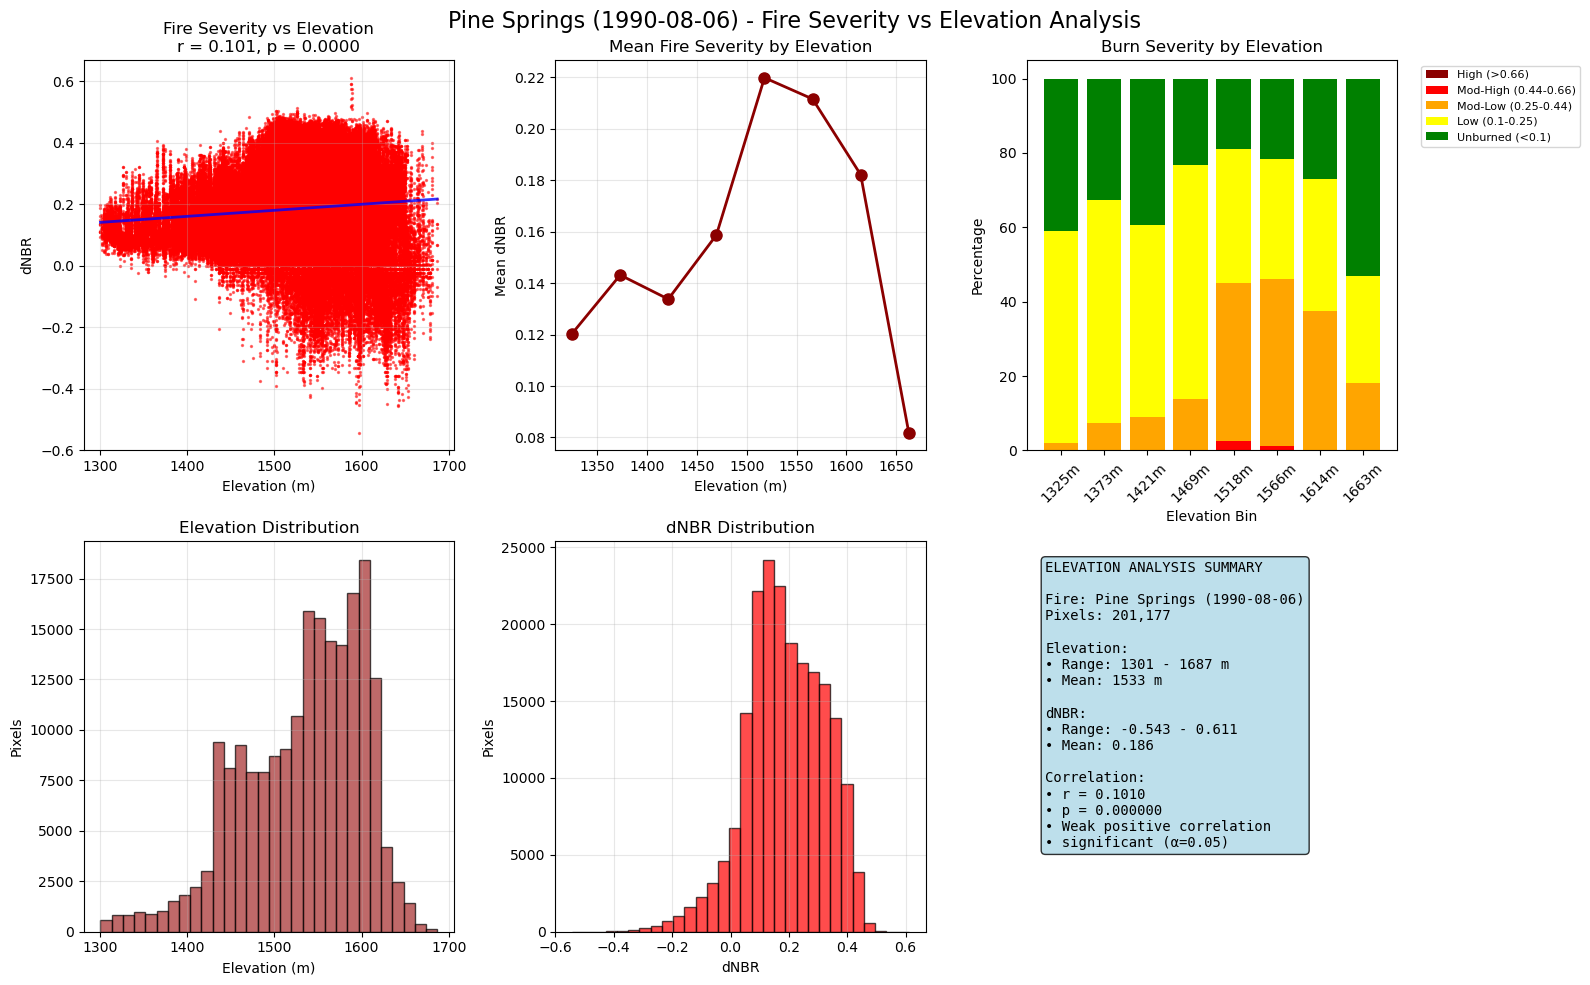


FINAL ANALYSIS RESULTS

Fire Information:
Name: Pine Springs
ID: None
Year: 1990
Fire Date: 1990-08-06
Satellite: LANDSAT-5

Analysis Dates:
Pre-fire imagery: 1990-07-23
Post-fire imagery: 1991-08-06

Spatial Analysis:
Total analyzed pixels: 201,177
Fire area: 0.03242116 square degrees

Elevation Summary:
Range: 1301 - 1687 m
Mean: 1533 m
Relief: 386 m

Fire Severity Summary:
dNBR Range: -0.543 - 0.611
Mean dNBR: 0.186

Elevation-Fire Severity Correlation:
Pearson correlation: 0.1010
P-value: 0.000000
Statistical significance: Yes (α=0.05)

Interpretation:
There is a weak positive correlation between elevation and fire severity.
Higher elevations experienced more severe burning on average.

Detailed Severity by Elevation Zones:
Elevation (m) Mean dNBR  High Sev %  Mod-High %  Pixels  
-----------------------------------------------------------------
1325         0.120      0.0         0.0         2908    
1373         0.143      0.0         0.0         4898    
1421         0.134     

{'fire_info': {'geometry': <POLYGON ((-119.334 43.659, -119.334 43.66, -119.335 43.66, -119.336 43.661,...>,
  'fire_id': None,
  'incident_name': 'Pine Springs',
  'fire_year': 1990,
  'fire_date': Timestamp('1990-08-06 00:00:00')},
 'analysis_dates': {'pre_fire': Timestamp('1990-07-23 00:00:00'),
  'post_fire': Timestamp('1991-08-06 00:00:00')},
 'pre_fire_nbr': <xarray.DataArray (band: 1, y: 363, x: 871)> Size: 3MB
 dask.array<getitem, shape=(1, 363, 871), dtype=float64, chunksize=(1, 263, 527), chunktype=numpy.ndarray>
 Coordinates:
   * band         (band) int64 8B 1
   * x            (x) float64 7kB 2.966e+05 2.966e+05 ... 3.226e+05 3.227e+05
   * y            (y) float64 3kB 4.843e+06 4.843e+06 ... 4.832e+06 4.832e+06
     spatial_ref  int64 8B 0,
 'post_fire_nbr': <xarray.DataArray (band: 1, y: 363, x: 871)> Size: 3MB
 array([[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [

In [2]:
run_fire_elevation_analysis_by_date('Pine Springs', '1990-08-06', pre_fire_days=14)

In [ ]:
# "Glacier", "Whiting Sp", "Sheep Mountain", "Snowshoe", 'Pine Springs', 'Buck Springs' '604'

FIRE SEVERITY + ELEVATION ANALYSIS BY DATE
Loading fire data to find 'Glacier'...
Found 2 fires matching 'Glacier':
  0: Glacier (1989) - 5244.7 ha - None
  1: Glacier (2021) - 6.4 ha - 2021-ORMAF-021309
Using: Glacier (1989)

Selected Fire: Glacier (None)
Fire Year: 1989
Fire Area: 0.00425670 square degrees

Analysis Timeline:
Fire date: 1989-07-27
Pre-fire target: 1989-06-27 (30 days before)
Post-fire target: 1990-07-27 (365 days after)

1. Searching for pre-fire imagery...
Attempt 1: Searching with +/-30 day buffer...
Searching Landsat 5 imagery from 1989-05-28 to 1989-07-27
Found 1 Landsat 5 images:
  Image 1: 1989-06-10, 7.0% clouds, 17 days from target

2. Calculating pre-fire NBR...
Processing image from: 1989-06-10T18:05:58.307000Z
Cloud cover: 7.0%
Using NIR band: nir08, SWIR2 band: swir22
Cropped to fire area: NIR (1, 451, 351), SWIR2 (1, 451, 351)
Valid pixels within fire polygon: 41905/41905 (100.0%)
NBR calculated successfully
Pre-fire NBR: Mean 0.458

3. Searching for pos

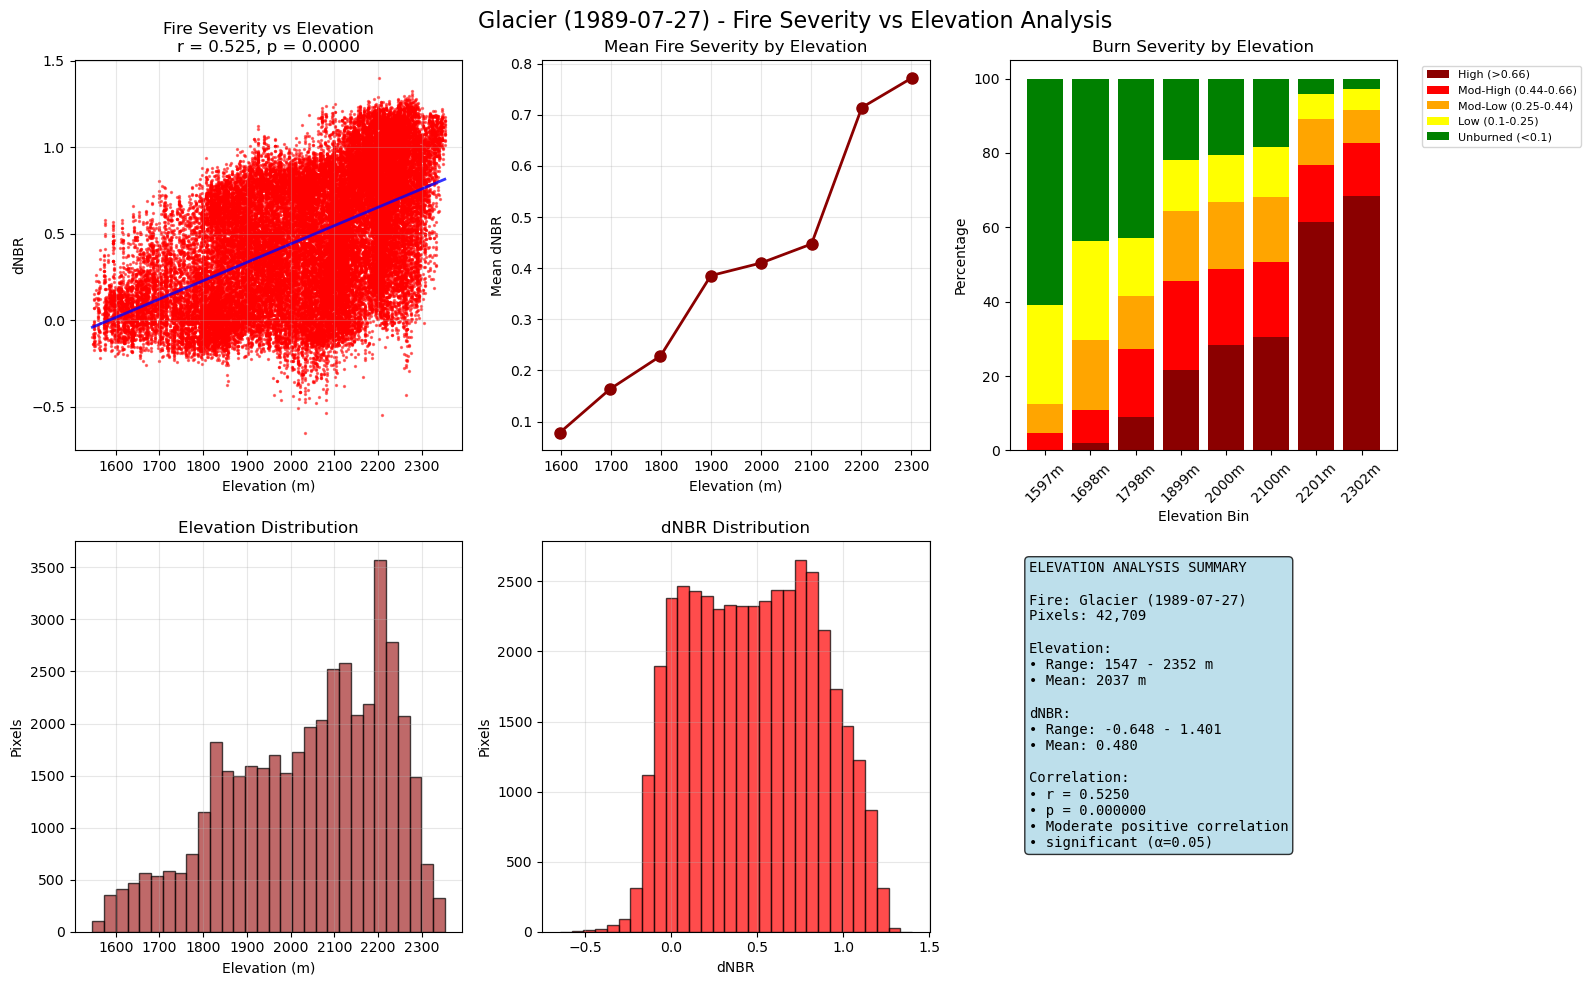


LANDSAT 5 FIRE SEVERITY + ELEVATION ANALYSIS RESULTS

Fire Information:
Name: Glacier
ID: None
Year: 1989
Fire Date: 1989-07-27
Satellite: Landsat 5 (30m resolution)

Analysis Dates:
Pre-fire imagery: 1989-06-27
Post-fire imagery: 1990-07-27

Spatial Analysis:
Total analyzed pixels: 42,709
Fire area: 0.00425670 square degrees

Elevation Summary:
Range: 1547 - 2352 m
Mean: 2037 m
Relief: 806 m

Fire Severity Summary:
dNBR Range: -0.648 - 1.401
Mean dNBR: 0.480

Elevation-Fire Severity Correlation:
Pearson correlation: 0.5250
P-value: 0.000000
Statistical significance: Yes (α=0.05)

Interpretation:
There is a moderate positive correlation between elevation and fire severity.
Higher elevations experienced more severe burning on average.

Detailed Severity by Elevation Zones:
Elevation (m) Mean dNBR  High Sev %  Mod-High %  Pixels  
-----------------------------------------------------------------
1597         0.078      0.1         4.5         1199    
1698         0.164      1.9        

In [3]:
run_fire_elevation_analysis_by_date('Glacier', '1989-07-27', pre_fire_days=30);